In [264]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as mpatches
import numpy as np
import math

import mahotas as mh
import cv2
from PIL import Image

import copy, os

from skimage import io, exposure
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, opening, square, disk


import matplotlib.pyplot as plt

%matplotlib notebook

import numpy as np

from skimage.draw import disk as pdisk

import cv2

 

center = [415, 337]

lims = [600,600]

radius = 120

r = 5

center_dist_in_r = 4

​

   

def calc_lums(frame):

    unit_lums = np.array([])

    x = 0

    while x < lims[0]:

        y = 0

        while y < lims[1]:

            if pow(x-center[0],2) + pow(y-center[1],2) < pow(radius, 2):

                #dorysować kropki
from skimage.color import label2rgb, rgb2gray

from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

from skimage.filters import threshold_local, threshold_otsu, threshold_li, threshold_multiotsu, rank
from skimage.filters import sobel

from scipy.stats import skew
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
import csv

In [2]:
PRECISION = 50

In [3]:
class IegImgParams(): 
    def __init__(self, path, thre, skewness, bgr):
        self.path = path
        self.thre = thre
        self.skewness = skewness
        self.bgr = bgr
        self.dots = np.array([])

In [4]:
class Approximation(): 
    def __init__(self, reg_props, approx_patch, intensity,  idno):
        self.reg_props = reg_props
        self.approx_patch = approx_patch
        self.intensity = intensity
        self.idno = idno

In [5]:
def background_filter(flattened_img):
    hist, bins = np.histogram(flattened_img, int(pow(PRECISION, 2)/20))
    mode_idx = np.argmax(hist)
    mode = bins[mode_idx]
    return mode

In [6]:
def reflect(image_ts):
    height = image_ts.shape[0]
    image_ts = np.transpose(image_ts)
    to_ret = np.copy(image_ts)
    for col_no, column in enumerate(image_ts):
        nonzero = False
        idx = 0
        while not nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        start_idx = idx - 1
        while nonzero and idx < height:
            nonzero = column[idx] > 0
            idx += 1
        stop_idx = idx - 1
        reflection = np.flip(column[start_idx:stop_idx])
        reflect_offset_up = start_idx - len(reflection)
        reflect_offset_down = stop_idx + len(reflection)
        to_ret[col_no][max(0, reflect_offset_up):start_idx] = reflection[max(0, -reflect_offset_up):]
        to_ret[col_no][stop_idx:min(reflect_offset_down, height)] = reflection[:min(len(reflection)+1, height - stop_idx)]
    return np.transpose(to_ret)

In [7]:
def calculate_ieg_segm_mask(image_ts):
    reflected = reflect(image_ts)
    
    background = ndi.generic_filter(reflected, background_filter, size=50)
    skewness = skew(image_ts[image_ts>0])
    mask = image_ts > (threshold_otsu(image_ts[image_ts>0])*5/skewness + background)
    
    return threshold_otsu(image_ts[image_ts>0]), background, skewness



def calculate_ieg_segm_params(image_ts):
    
    reflected = reflect(image_ts)
    background = ndi.generic_filter(reflected, background_filter, size=PRECISION)
    skewness = skew(image_ts[image_ts>0])
    
    
    return threshold_otsu(image_ts[image_ts>0]), background, skewness

In [33]:
def ieg_segmentation(image_ts, thresh_down, thresh_up, thresh_range, mask): 

        
    elev_map = sobel(image_ts)
    distance = ndi.distance_transform_edt(mask)
    local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
                                labels=mask)
    markers = ndi.label(local_maxi)[0]
    labels = watershed(-elev_map, markers, mask=mask)
    label_image = label(labels, connectivity = 1)
    
    
    masked = np.ma.masked_array(data = image_ts, mask = mask, fill_value = 0).filled()

    intensities_normalized = np.array([])
    dots = np.array([])
    
    for region in regionprops(label_image, intensity_image=image_ts):
        reg_app_w_bgr = pdisk(region.centroid, 7, shape = image_ts.shape)
        reg_approx = pdisk(region.centroid, 5, shape = image_ts.shape)
        reg_intensity = 2*np.sum(image_ts[reg_approx])-np.sum(image_ts[reg_app_w_bgr])
        circ = mpatches.Circle((region.centroid[1], region.centroid[0]), 5, 
                               fill=False, edgecolor='red', linewidth=2)
        new_dot = Approximation(region, copy.copy(circ), reg_intensity, len(dots))
        intensities_normalized = np.append(intensities_normalized, reg_intensity)
        dots = np.append(dots, new_dot)


    return dots, intensities_normalized

In [267]:
scan_path_root = "/mnt/ula/catfish/test_scans/"

suffix = "/2.tif"
overlay_suffix = "/overlay2.tif"
csv_suffix = "/2.csv"

In [10]:
#MAIN loop to walk through img folder, looking for FOLDERS
results = np.array([])


for filename in os.listdir(scan_path_root):
    if os.path.isdir(scan_path_root + filename):
        print(scan_path_root + filename)
        img_path = scan_path_root + filename + suffix
        ieg_img = io.imread(img_path)
        thre, background, skewness = calculate_ieg_segm_params(ieg_img)
        res = IegImgParams(scan_path_root + filename, thre, skewness, background)
        results = np.append(results, res)

/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_16_hipp_left_skan_2019-10-11_135612
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_3_hipp_right_skan_2019-10-08_135307
/mnt/ula/catfish/test_scans/CA1_right_glass_19_rat_14_hipp_right_skan_2019-10-11_151922
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_20_hipp_right_skan_2019-10-14_130039
/mnt/ula/catfish/test_scans/CA1_left_glass_19_rat_13_hipp_left_skan_2019-10-11_114708
/mnt/ula/catfish/test_scans/CA1_right_glass_1_rat_2_hipp_right_skan_2019-10-08_113103
/mnt/ula/catfish/test_scans/CA1_left_glass_23_rat_17_hipp_left_skan_2019-10-14_101906
/mnt/ula/catfish/test_scans/CA1_right_glass_23_rat_19_hipp_right_skan_2019-10-14_114530
/mnt/ula/catfish/test_scans/CA1_left_glass_1_rat_3_hipp_left_skan_2019-10-08_130731
/mnt/ula/catfish/test_scans/CA1_right_glass_15_rat_11_hipp_right_skan_2019-10-11_102835
/mnt/ula/catfish/test_scans/CA1_right_glass_10_rat_6_hipp_right_skan_2019-10-09_114941
/mnt/ula/catfish/test_scans/CA1_right_glass_1_r

<IPython.core.display.Javascript object>


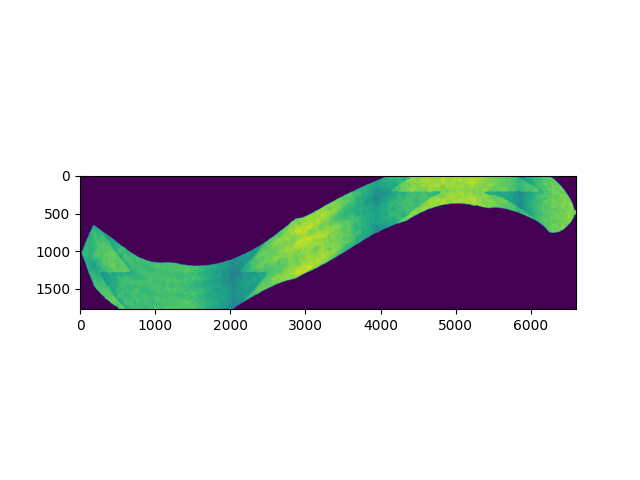

[]

In [11]:
plt.imshow(background)
plt.plot()

In [15]:
len(results)

31

In [189]:
def plot_intensities_normalized(result, k1, k2):
    plt.ioff()
    ieg_img = io.imread(result.path + "/2.tif")

    mask = ieg_img > (result.thre*k1 + result.bgr*k2)
    dots, intensities_normalized = ieg_segmentation(ieg_img, 0, 30, 21, mask)

    result.dots = dots
    
    plt.hist(intensities_normalized, 200)
    plt.axvline(threshold_otsu(intensities_normalized), color = 'red')
    plt.axvline(threshold_li(intensities_normalized), color = 'green')
    plt.axvline(custom_intensity_thre(intensities_normalized), color = 'yellow')
    '''
    #figure = plt.gcf() # get current figure
    #print("len dots ",  len(dots), "skewness ", result.skewness)
    
    print(os.path.dirname(result.path) + hist_suffix)
    fig_path = os.path.dirname(result.path) + hist_suffix
    '''
    plt.show()
    plt.imshow(mask)
    plt.show()
    '''
    intensity_thre = threshold_otsu(intensities_normalized)
    ret_dots = np.array([])
    for dot in dots:
        if dot.intensity > intensity_thre:
            ret_dots = np.append(ret_dots, dot)
    print(len(dots), len(ret_dots))
    return ret_dots
    '''

In [78]:
for result in results:
    result.dots = plot_intensities_normalized(result, 0.2, 0.5)

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3045 1805


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


110430 55371


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3763 2181


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3909 2276


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


1891 1116


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


88561 39925


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3108 1822


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


1872 1125


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


48952 21160


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2847 1634


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2911 1716


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


63329 31559


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2907 1682


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3010 1733


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3665 2057


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2955 1692


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3202 1906


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


443 261


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


94792 47784


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2489 1439


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


64230 580


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2901 1653


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2916 1685


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


1993 1165


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3607 2131


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


77611 39486


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


2311 1295


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3201 1831


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


4081 2399


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


3438 1986


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


1999 1191


In [195]:
def show_hists(result, k1, k2):
    print(result.skewness)

    img = io.imread(result.path+suffix)
    plt.hist(img[img>0], 200)
    plt.axvline(threshold_otsu(img[img>0]), color = 'red')
    plt.show()

    plot_intensities_normalized(result, k1, k2)
    print(len(result.dots))
    

-0.8535709770516129


<IPython.core.display.Javascript object>


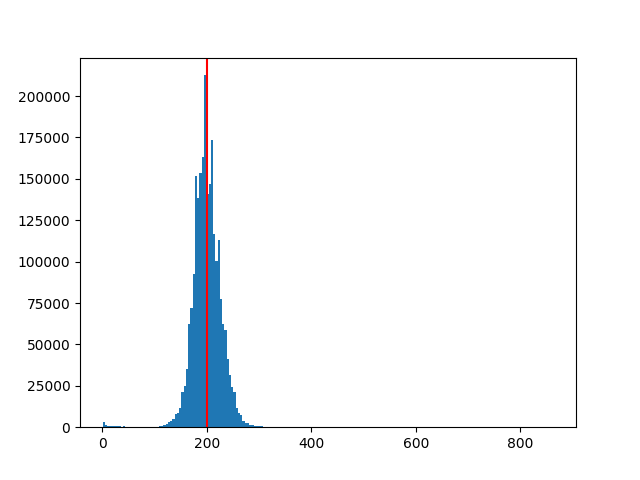

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


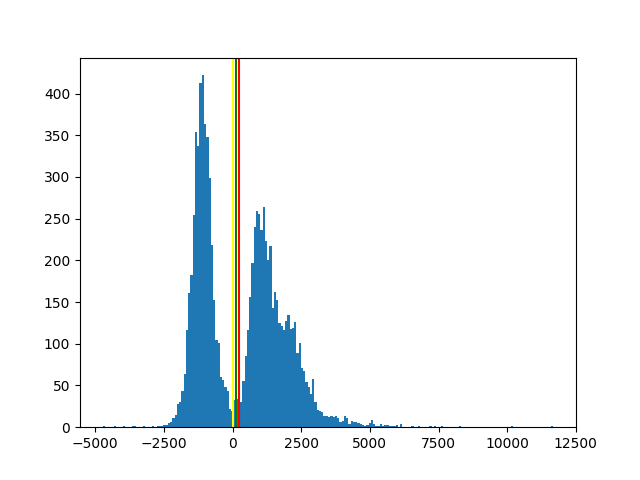

<IPython.core.display.Javascript object>


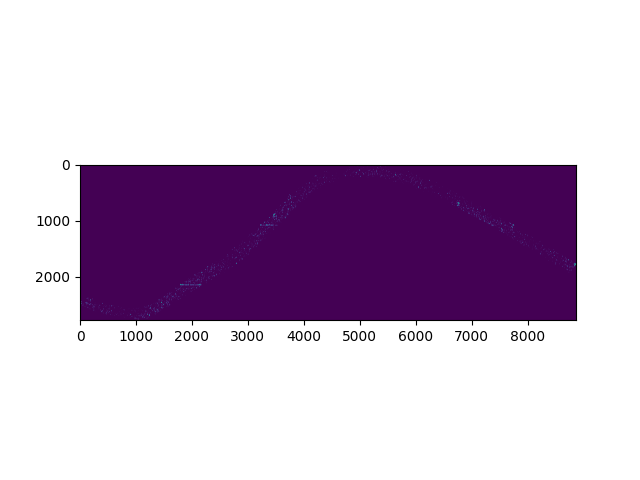

9208


In [196]:
show_hists(results[0], 0.2, 1)

12.904245335672831


<IPython.core.display.Javascript object>


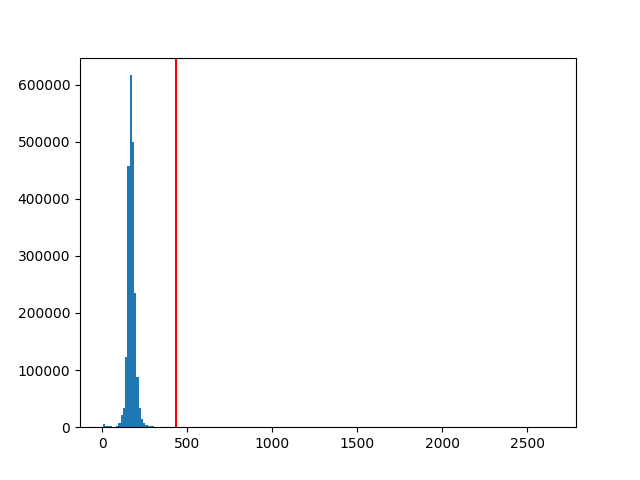

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


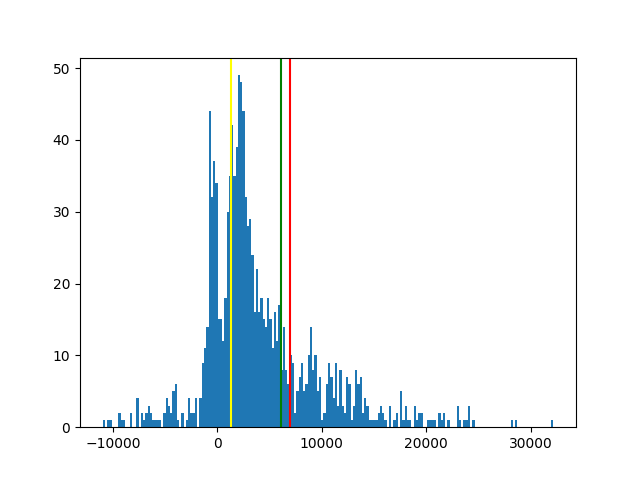

<IPython.core.display.Javascript object>


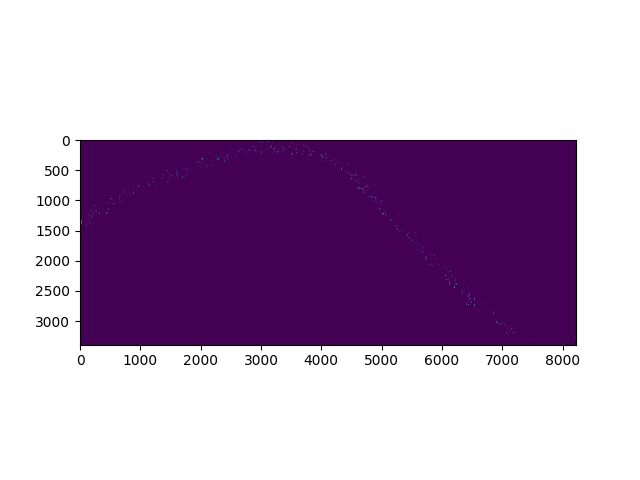

1239


In [206]:
show_hists(results[1], 0.2, 1)

-1.281029049119985


<IPython.core.display.Javascript object>


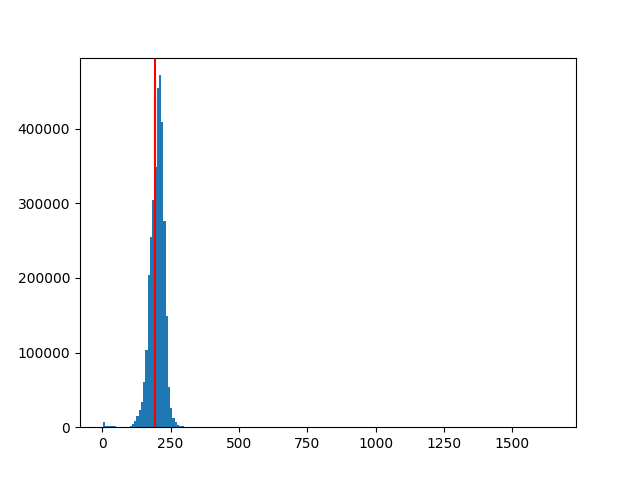

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


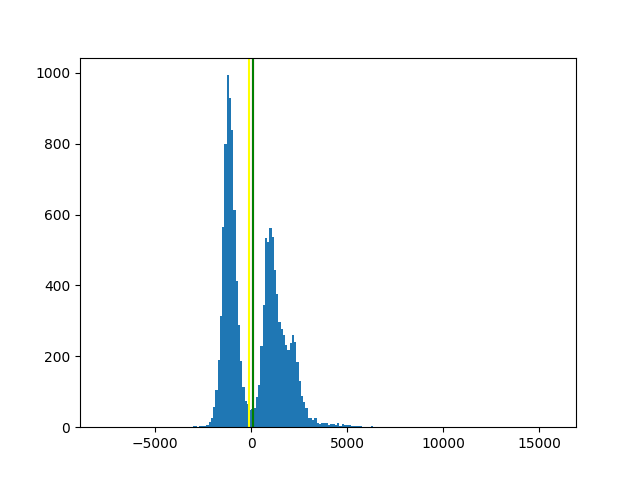

<IPython.core.display.Javascript object>


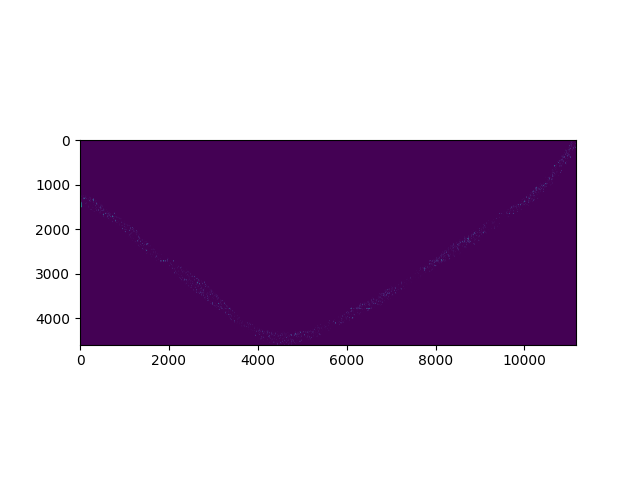

13330


In [203]:
show_hists(results[2], 0.2, 1)

-0.9691712093554815


<IPython.core.display.Javascript object>


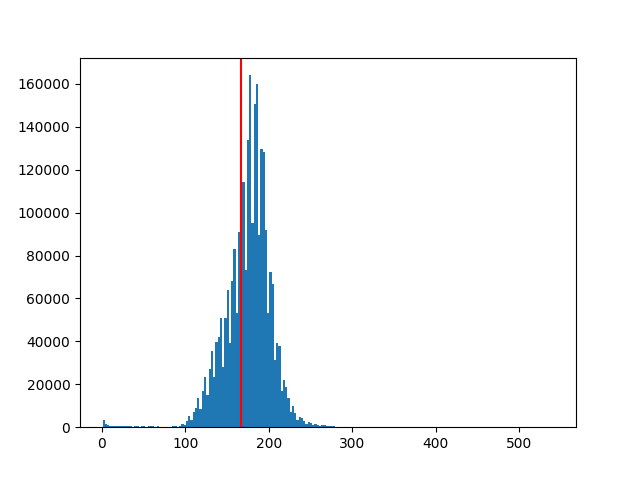

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


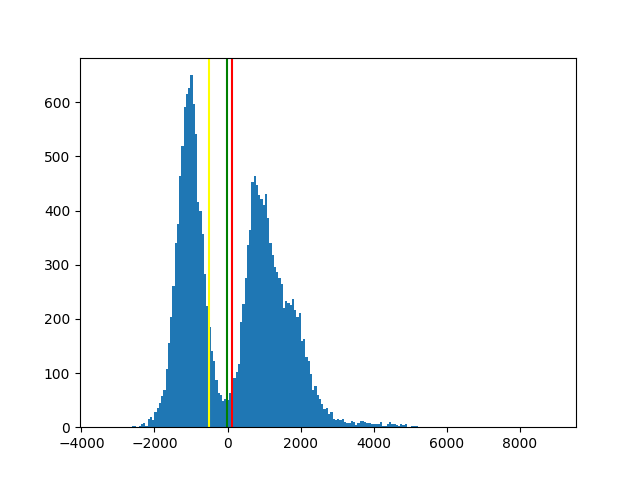

<IPython.core.display.Javascript object>


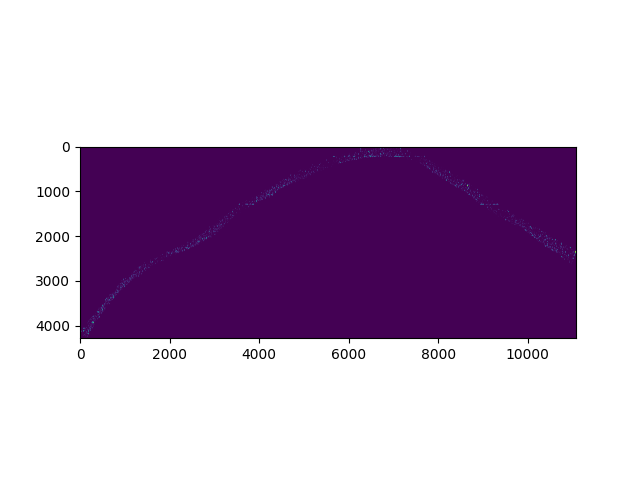

19063


In [204]:
show_hists(results[3], 0.2, 1)

-0.4274867148944419


<IPython.core.display.Javascript object>


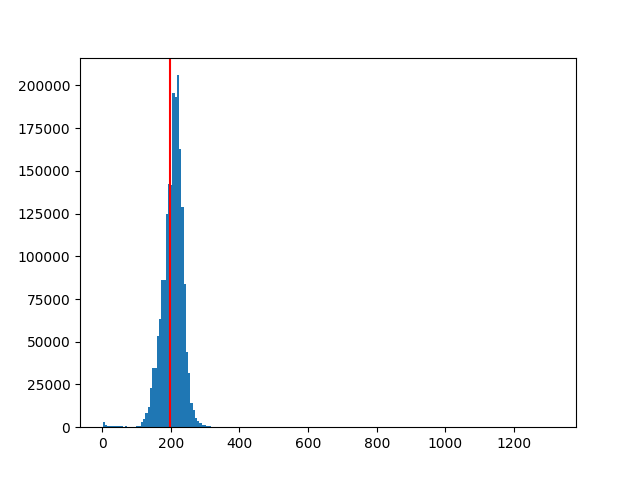

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


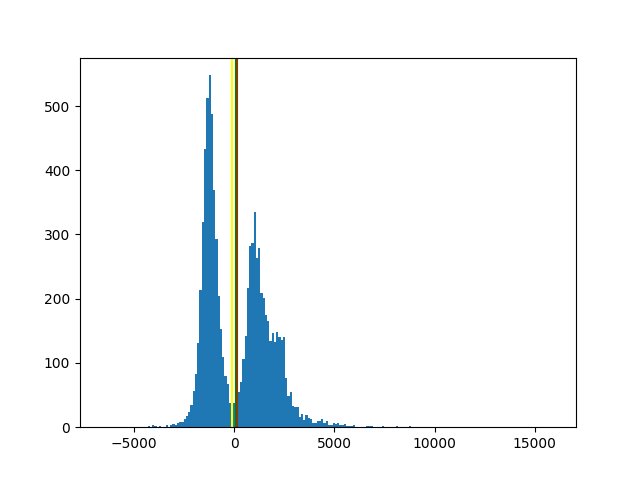

<IPython.core.display.Javascript object>


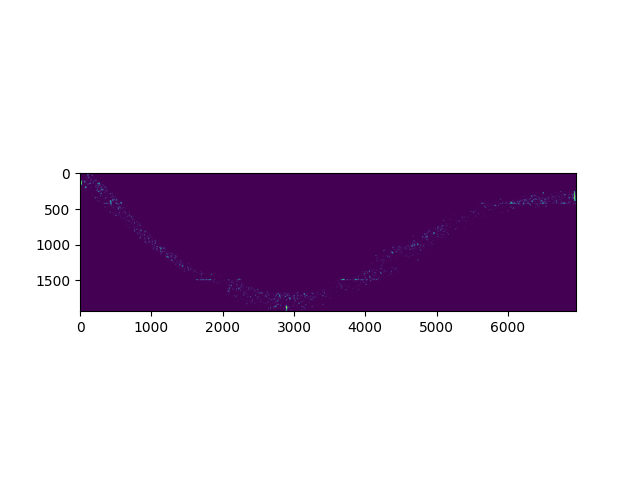

8609


In [205]:
show_hists(results[4], 0.2, 1)

14.557550068540806


<IPython.core.display.Javascript object>


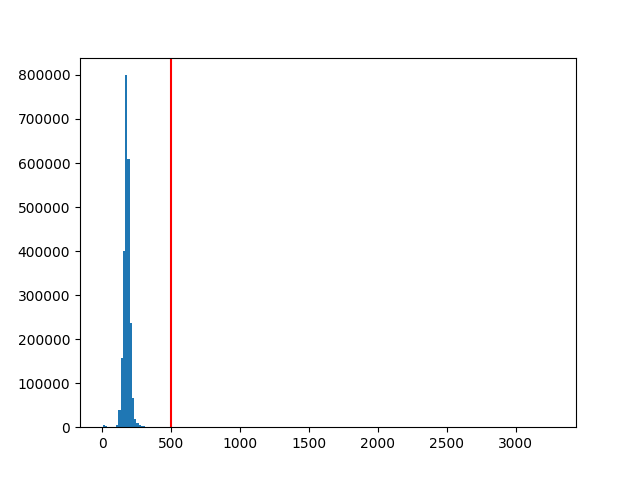

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


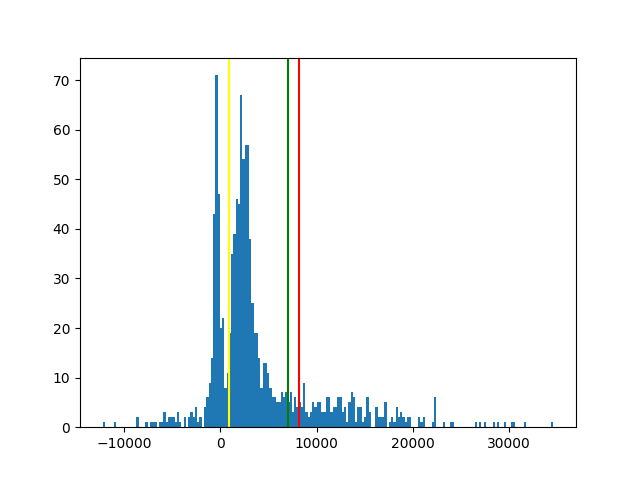

<IPython.core.display.Javascript object>


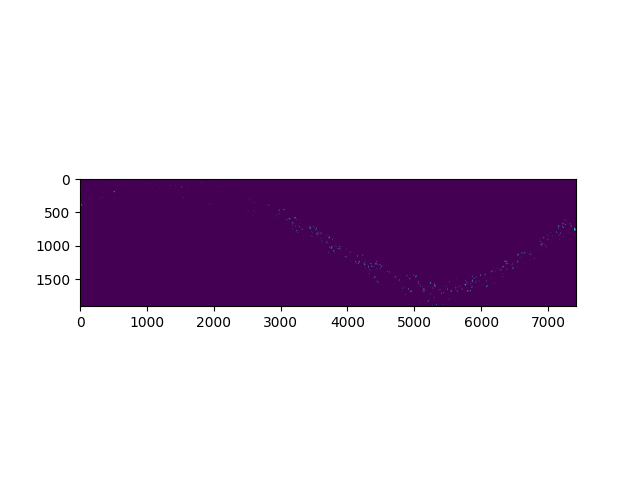

1143


In [207]:
show_hists(results[5], 0.2, 1)

2.720443374187218


<IPython.core.display.Javascript object>


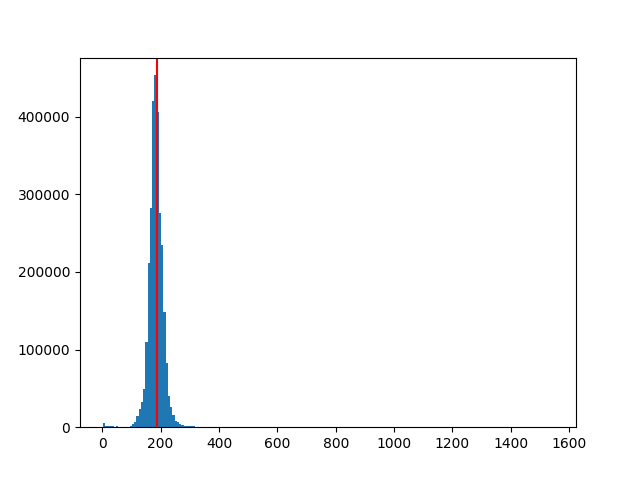

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


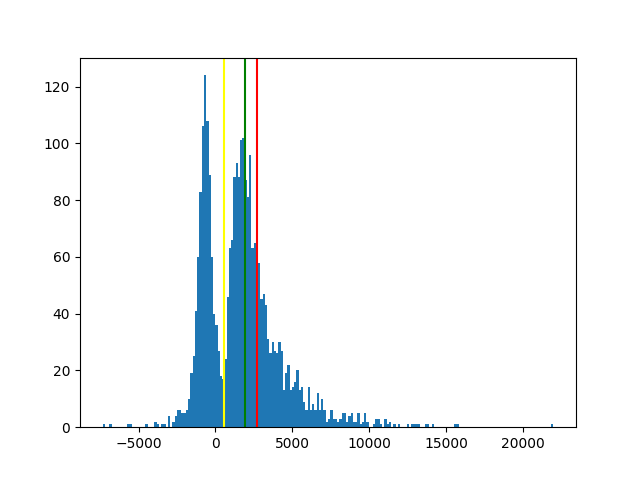

<IPython.core.display.Javascript object>


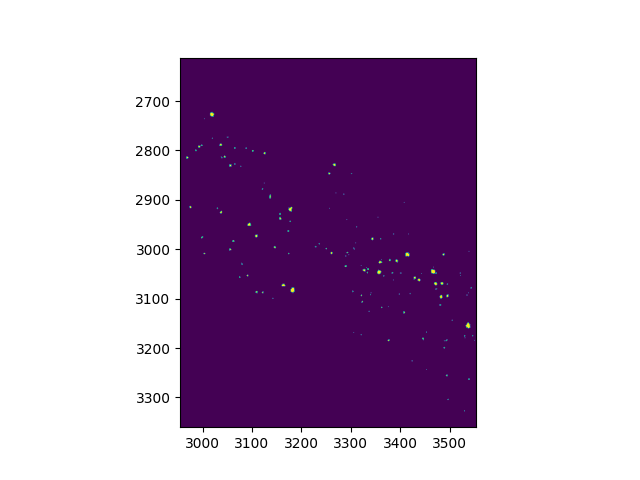

2742


In [210]:
show_hists(results[6], 0.4, 1)

0.38472940204392597


<IPython.core.display.Javascript object>


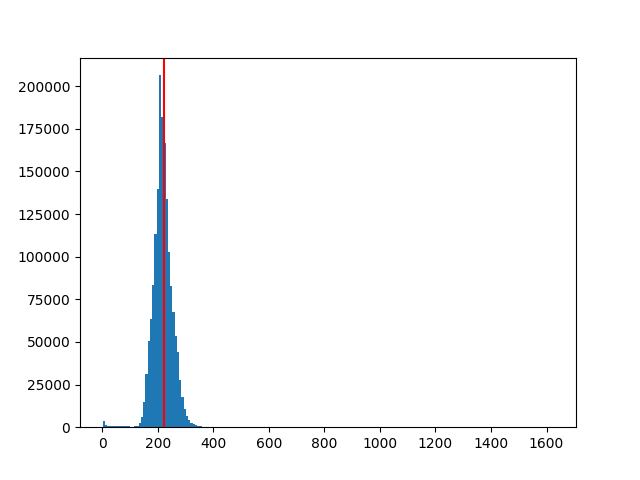

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


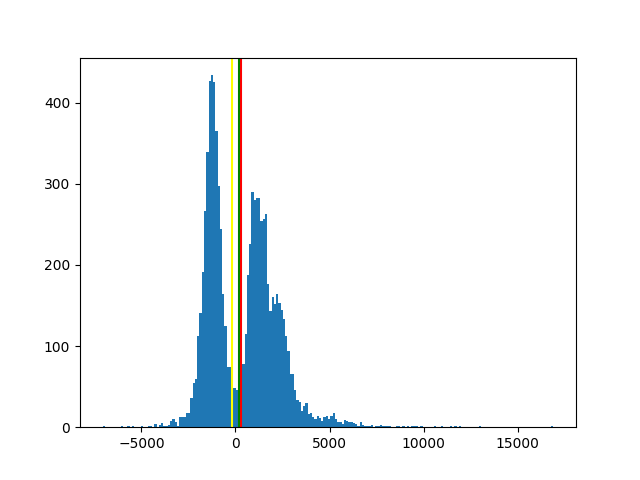

<IPython.core.display.Javascript object>


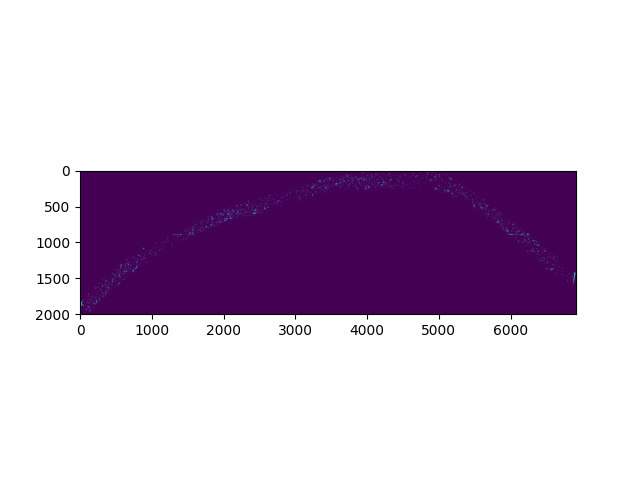

8762


In [211]:
show_hists(results[7], 0.2, 1)

16.284094800179695


<IPython.core.display.Javascript object>


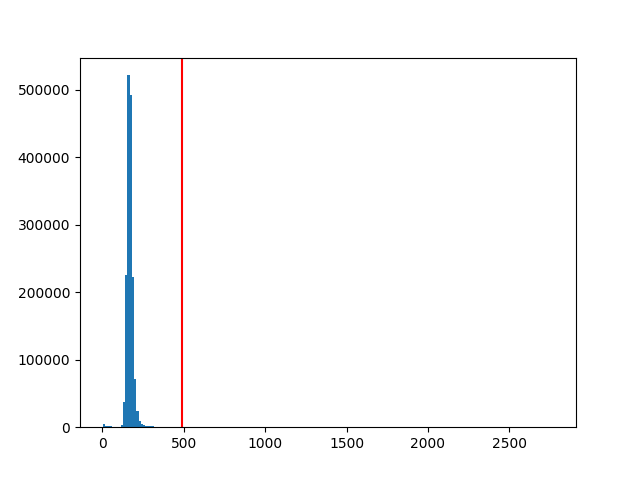

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


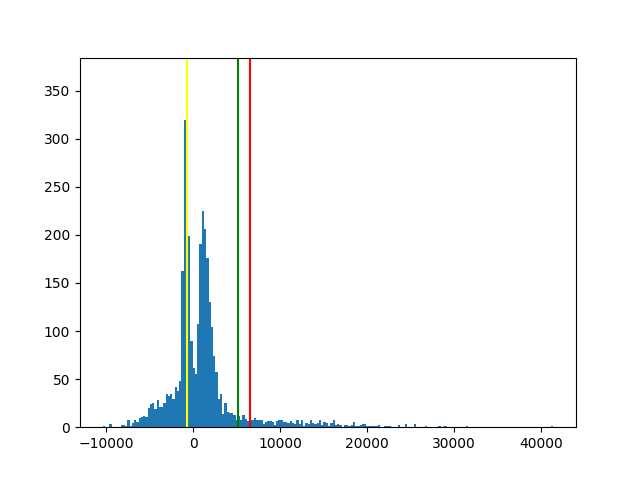

<IPython.core.display.Javascript object>


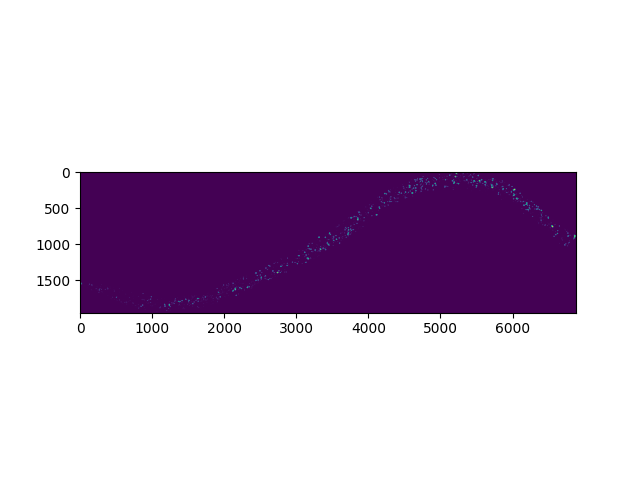

3510


In [217]:
show_hists(results[8], 0.1, 1)

7.751140950070866


<IPython.core.display.Javascript object>


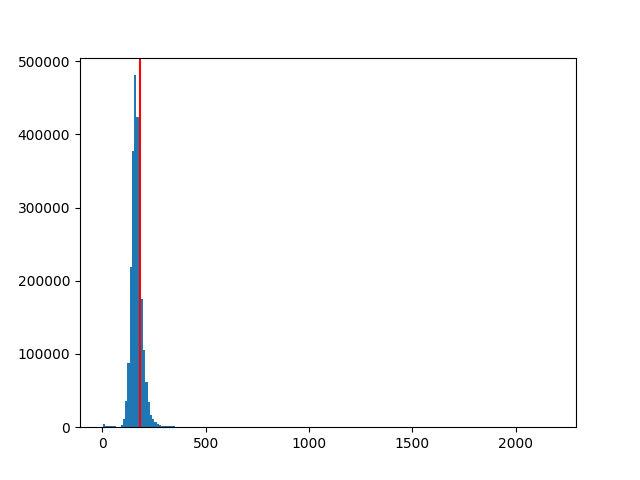

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


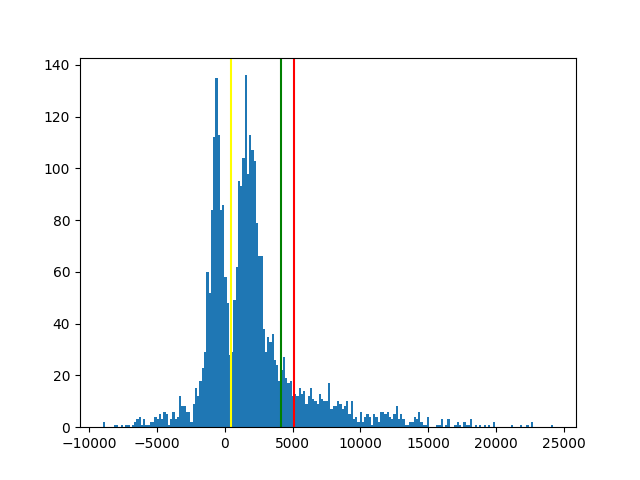

<IPython.core.display.Javascript object>


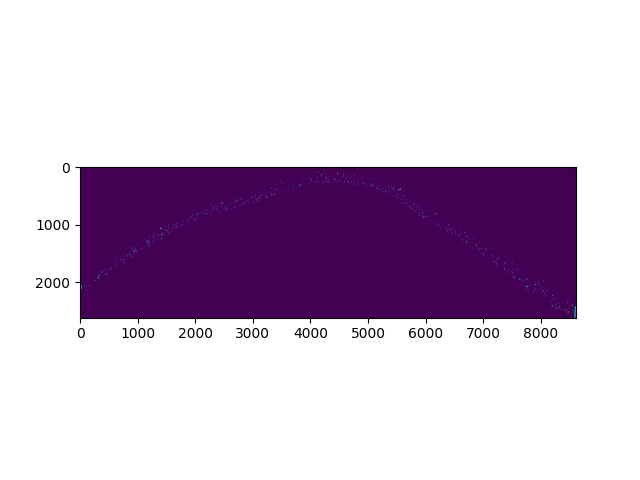

3063


In [216]:
show_hists(results[9], 0.4, 1)

-0.8312737062315233


<IPython.core.display.Javascript object>


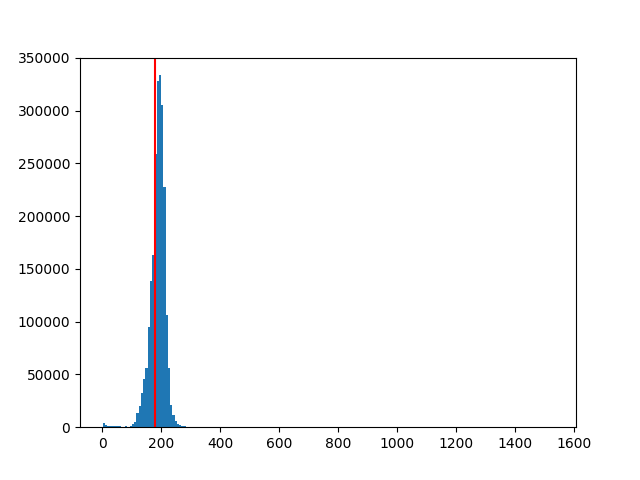

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


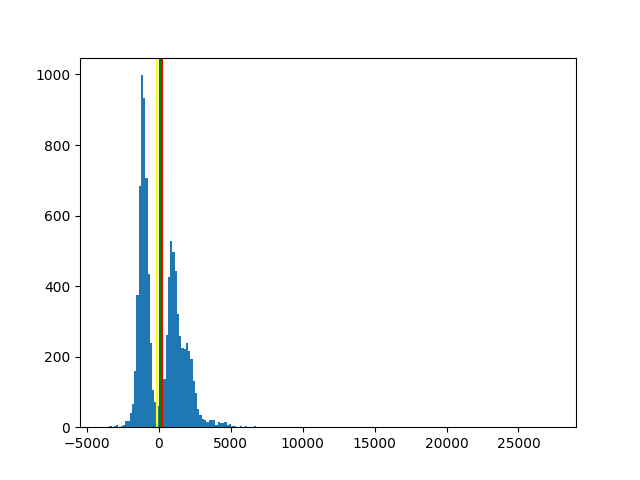

<IPython.core.display.Javascript object>


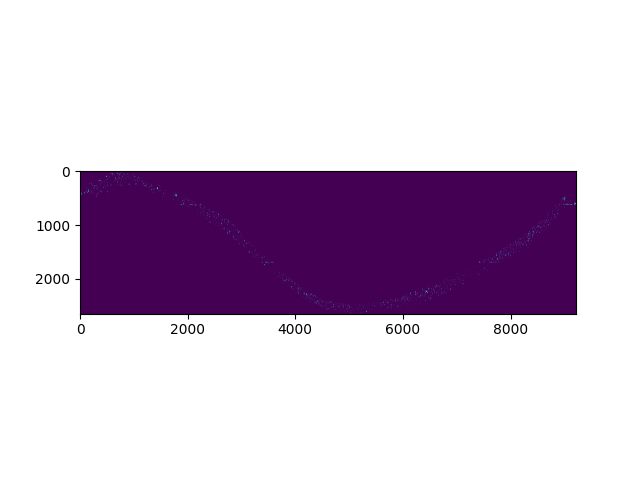

9577


In [214]:
show_hists(results[10], 0.2, 1)

12.627058507053995


<IPython.core.display.Javascript object>


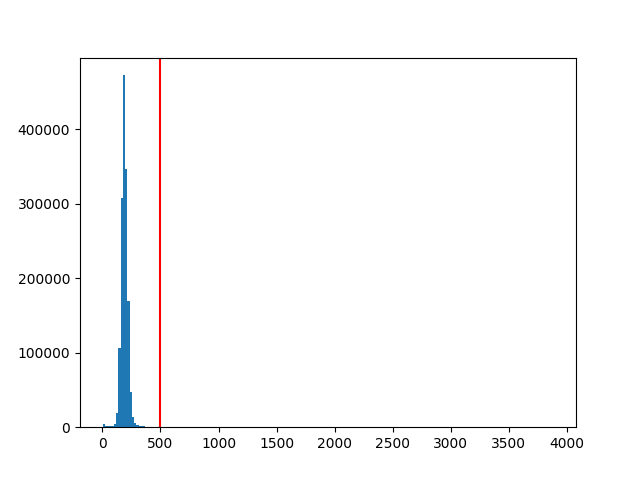

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


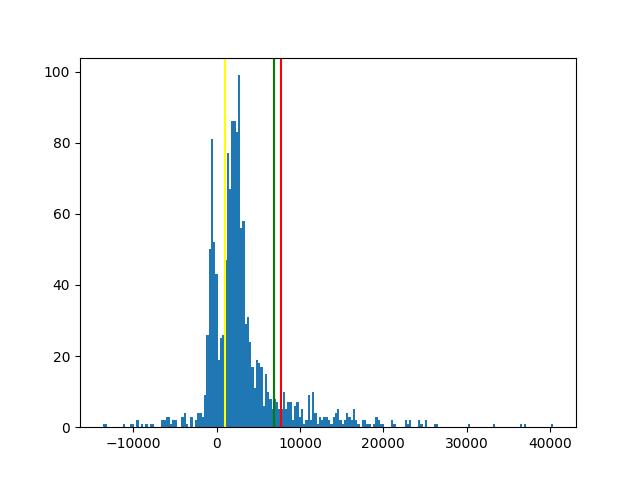

<IPython.core.display.Javascript object>


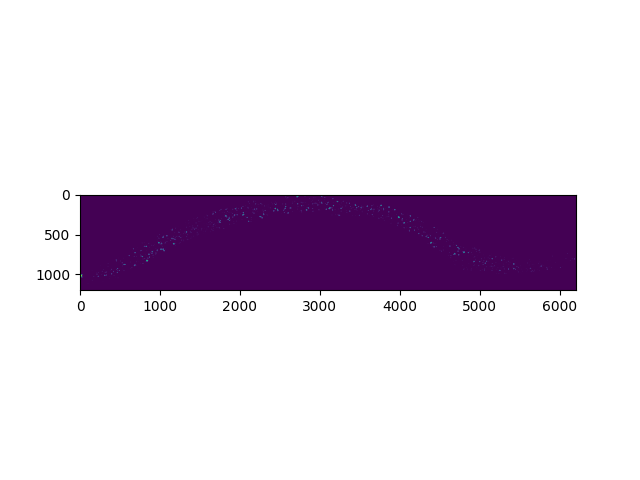

1438


In [218]:
show_hists(results[11], 0.2, 1)

-1.0114786103095452


<IPython.core.display.Javascript object>


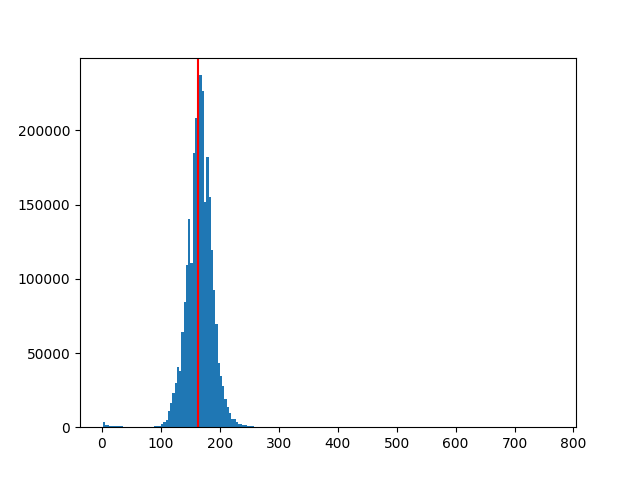

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


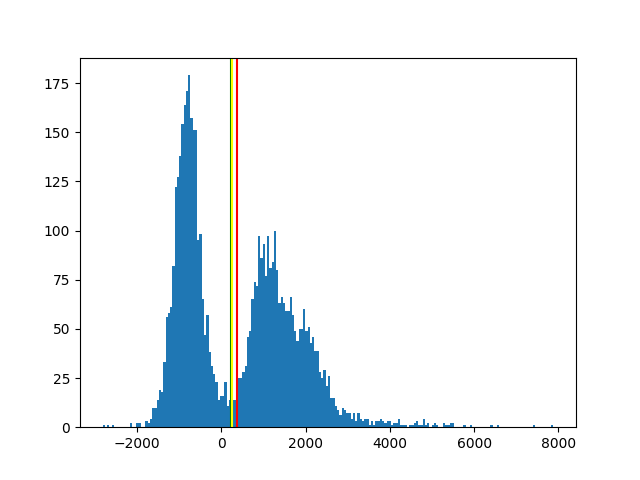

<IPython.core.display.Javascript object>


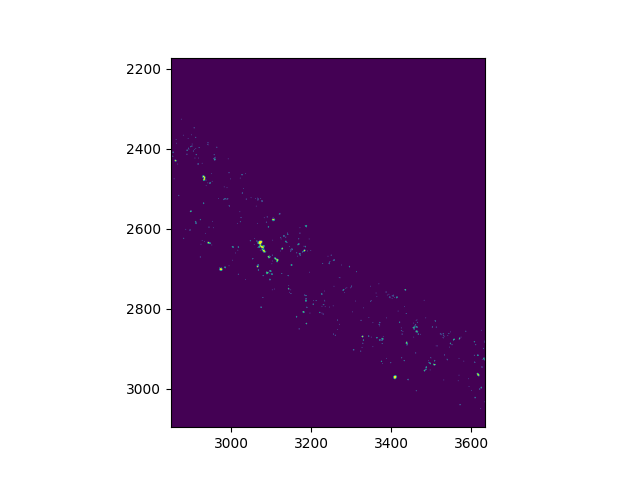

5003


In [223]:
show_hists(results[12], 0.3, 1)

0.8976052840191078


<IPython.core.display.Javascript object>


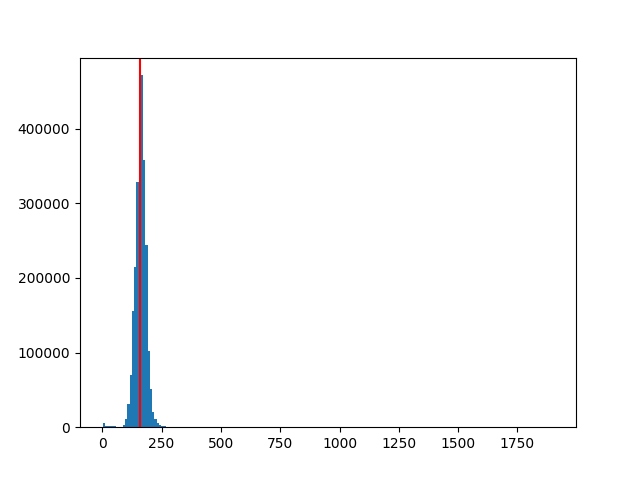

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


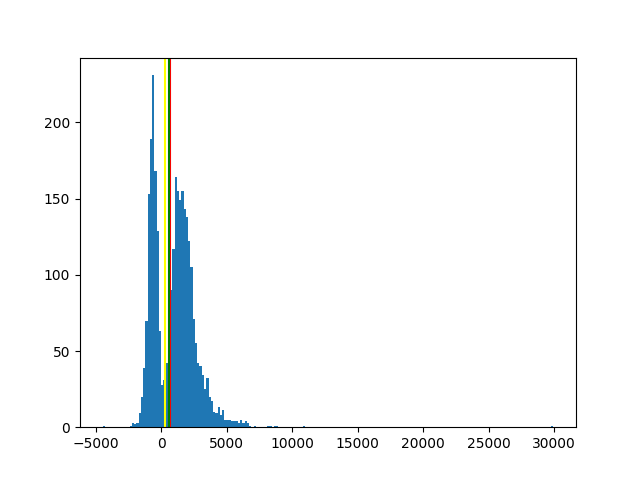

<IPython.core.display.Javascript object>


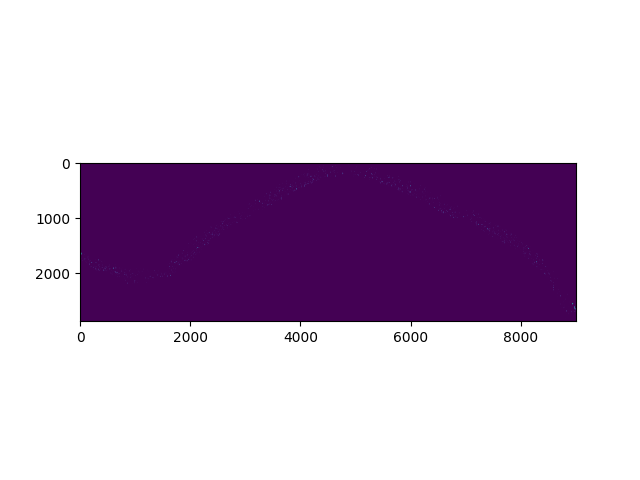

3009


In [224]:
show_hists(results[13], 0.4, 1)

5.274720968373332


<IPython.core.display.Javascript object>


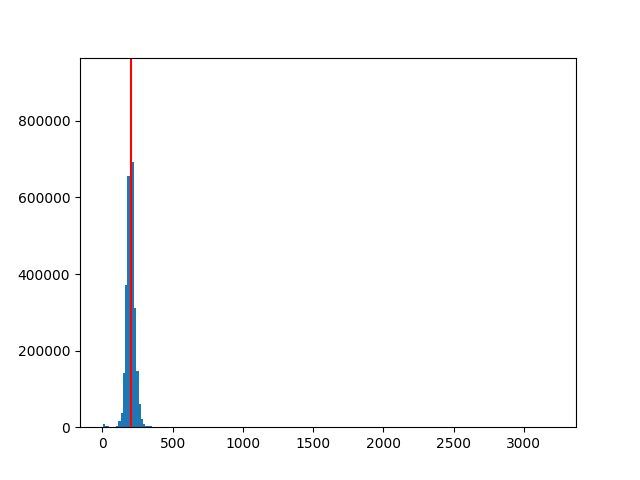

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


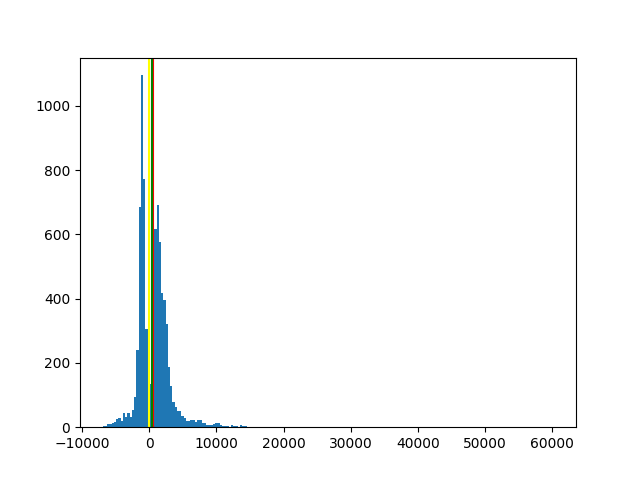

<IPython.core.display.Javascript object>


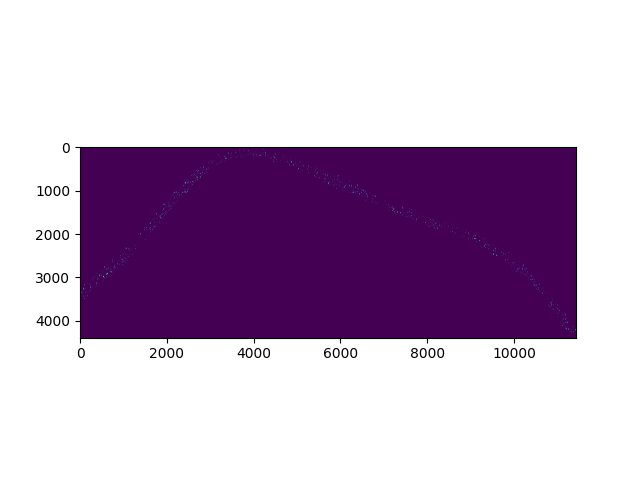

8067


In [227]:
show_hists(results[14], 0.25, 1)

0.379017724489984


<IPython.core.display.Javascript object>


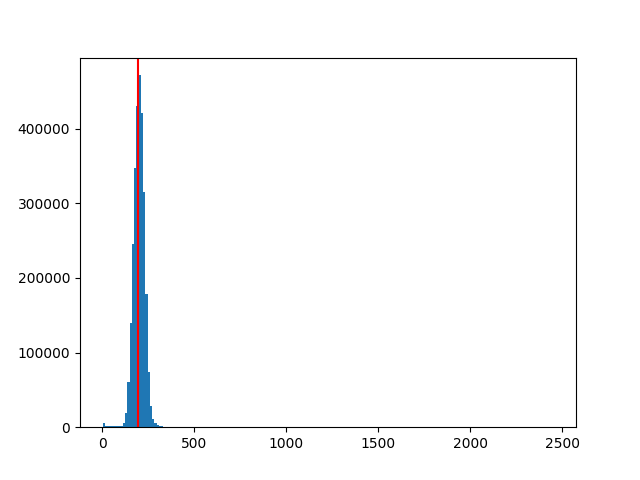

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


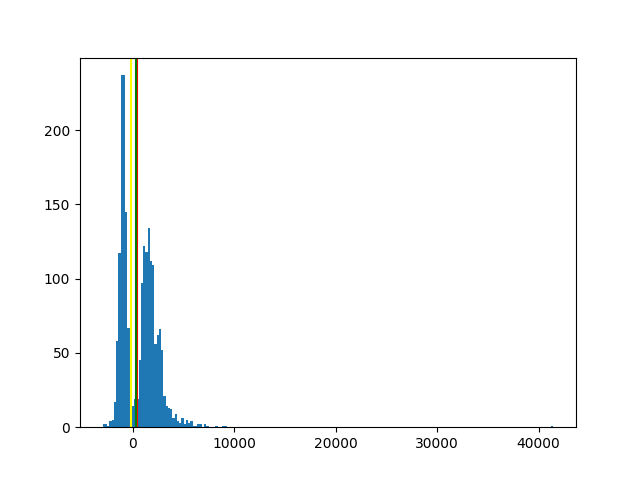

<IPython.core.display.Javascript object>


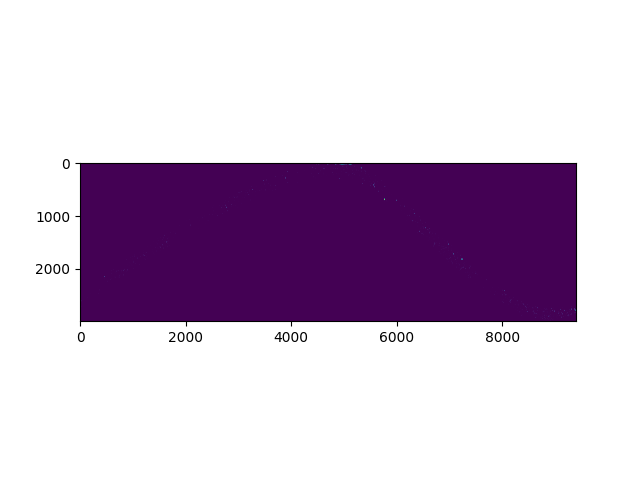

2068


In [228]:
show_hists(results[15], 0.3, 1)

0.2522317006206037


<IPython.core.display.Javascript object>


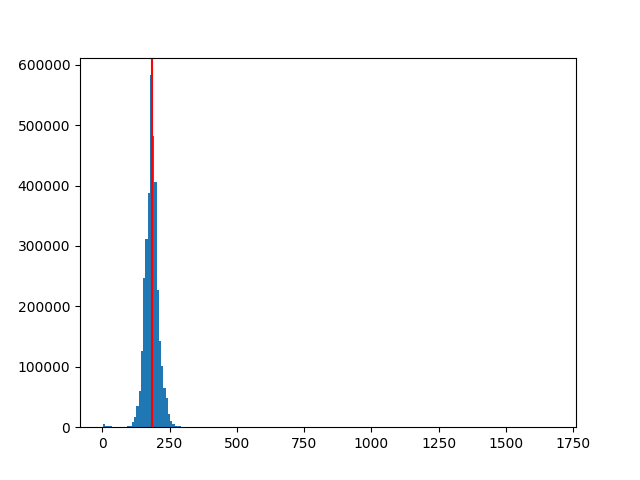

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


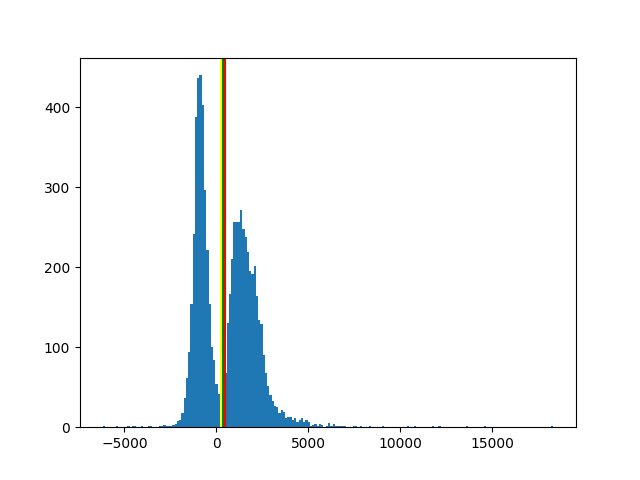

<IPython.core.display.Javascript object>


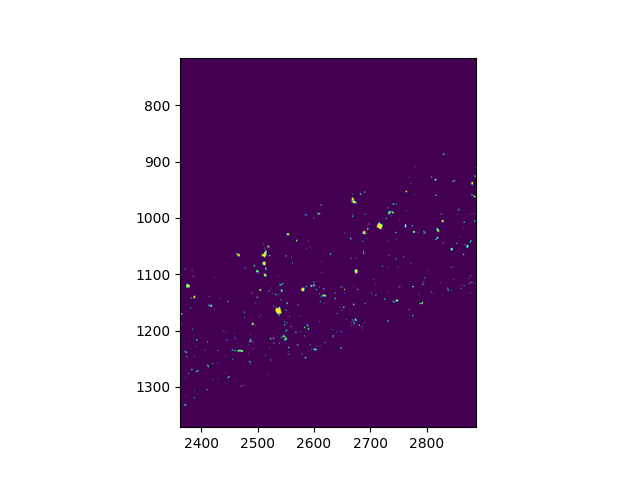

7253


In [229]:
show_hists(results[16], 0.3, 1)

-0.10810428979091785


<IPython.core.display.Javascript object>


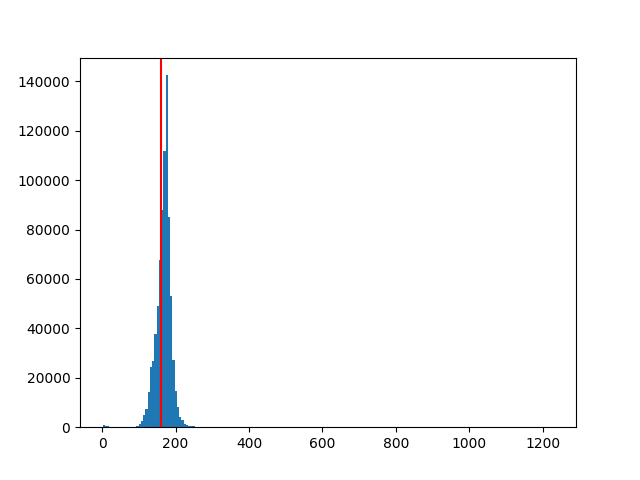

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


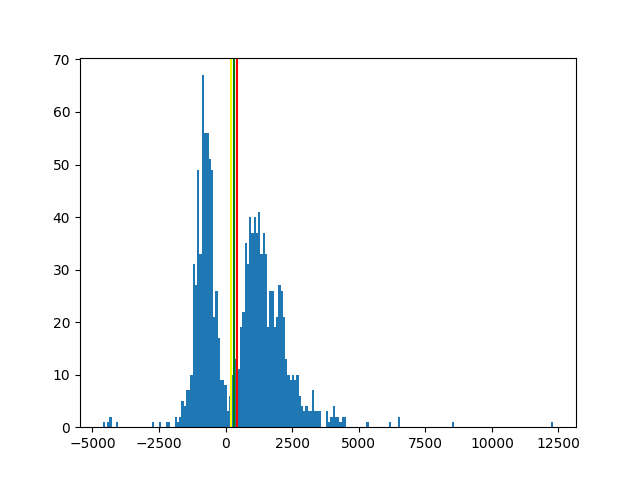

<IPython.core.display.Javascript object>


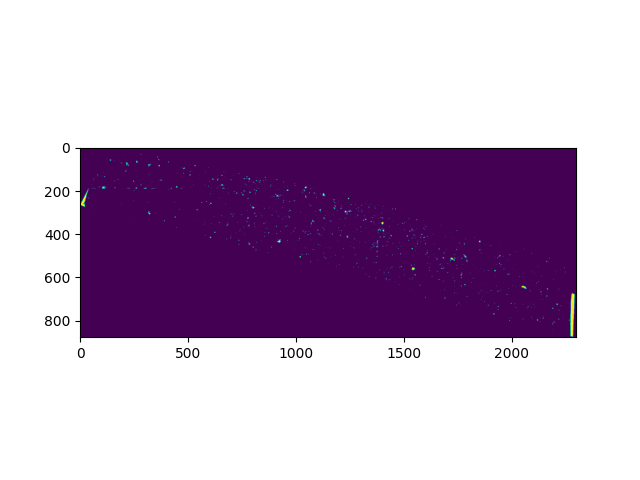

1324


In [230]:
show_hists(results[17], 0.3, 1)

15.770773230325933


<IPython.core.display.Javascript object>


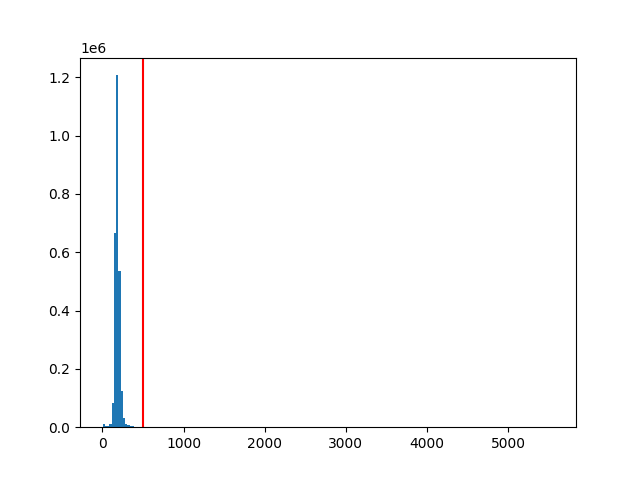

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


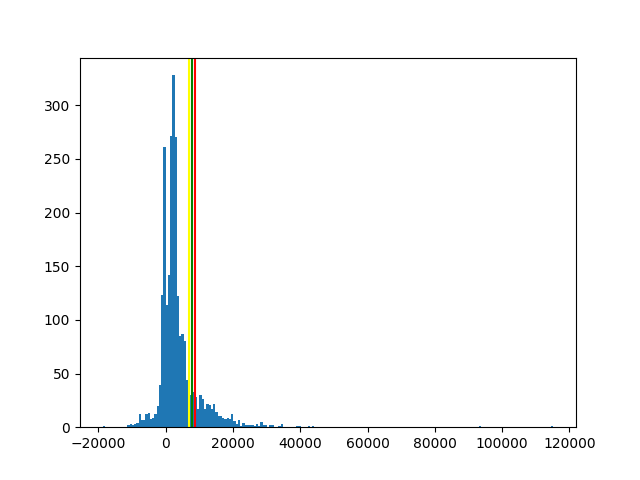

<IPython.core.display.Javascript object>


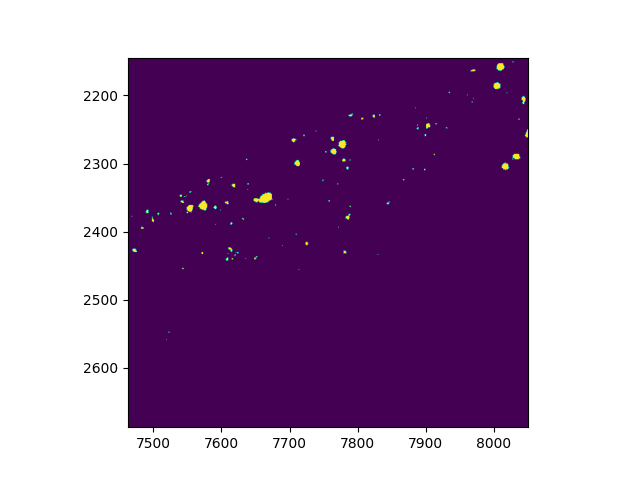

2521


In [236]:
show_hists(results[18], 0.2, 1)

4.37293362686735


<IPython.core.display.Javascript object>


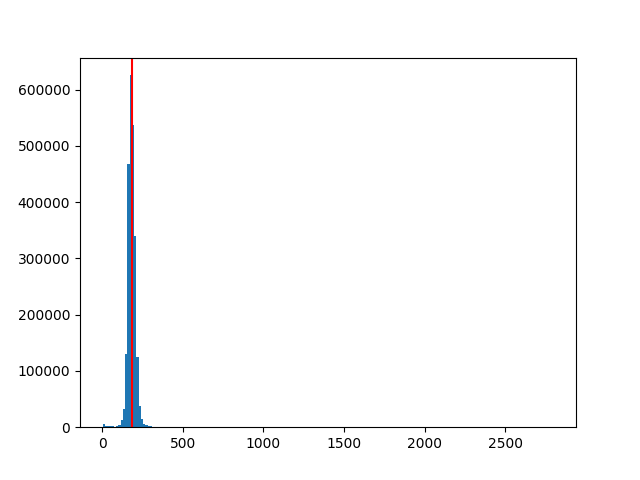

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


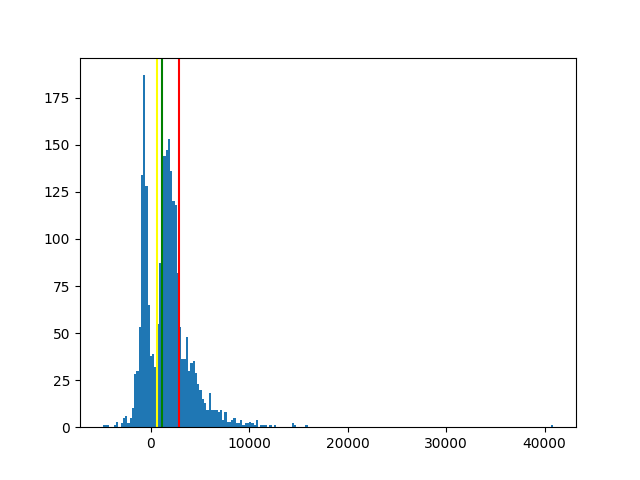

<IPython.core.display.Javascript object>


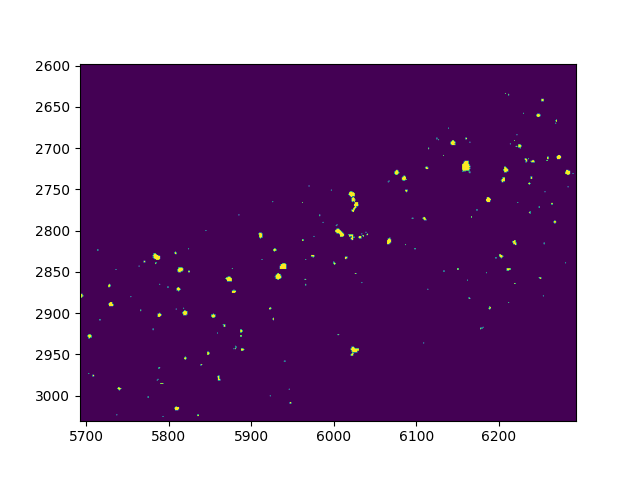

2421


In [237]:
show_hists(results[19], 0.4, 1)

13.537646810134756


<IPython.core.display.Javascript object>


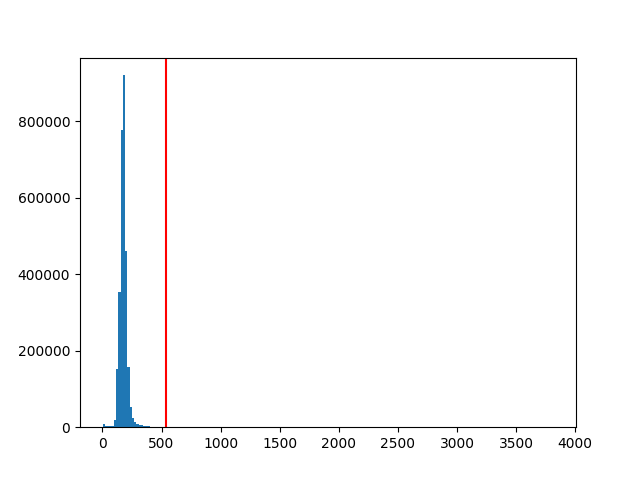

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


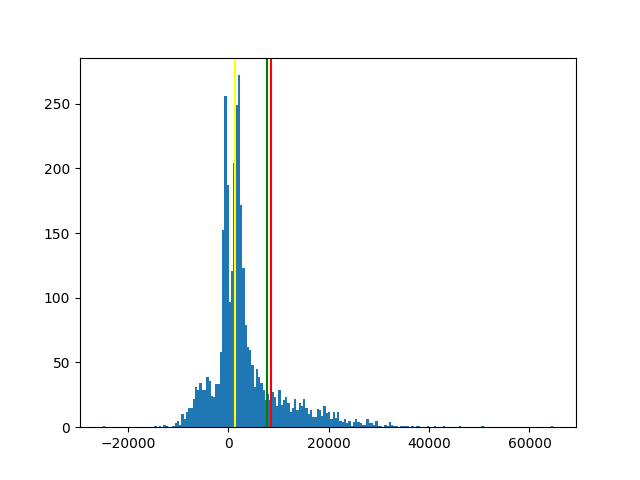

<IPython.core.display.Javascript object>


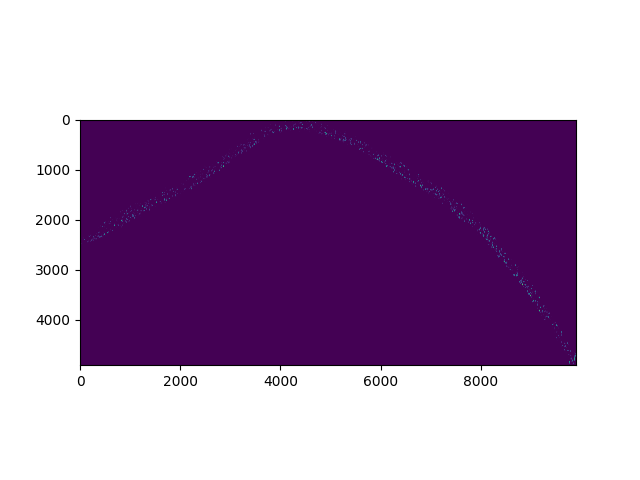

3373


In [239]:
show_hists(results[20], 0.15, 1)

5.8316332107176585


<IPython.core.display.Javascript object>


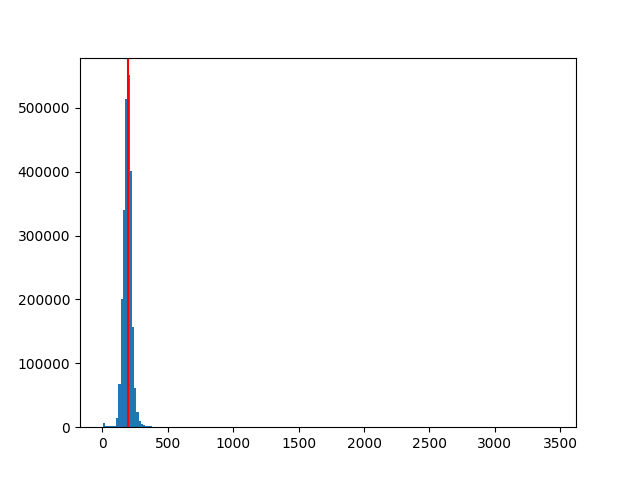

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


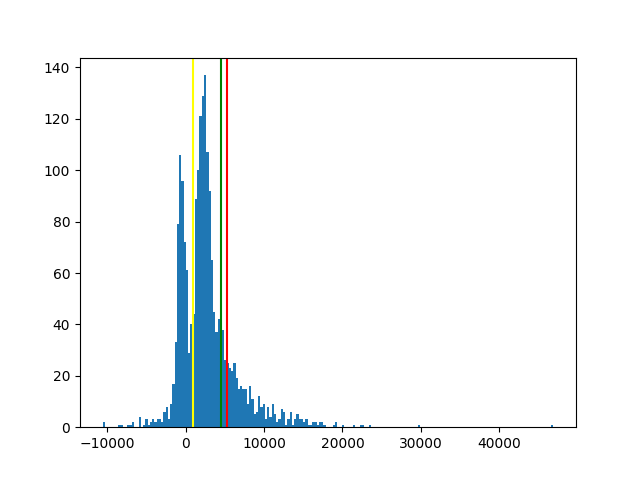

<IPython.core.display.Javascript object>


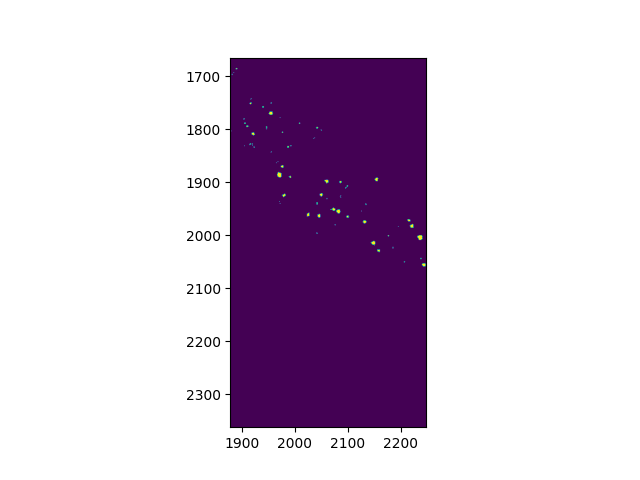

2045


In [247]:
show_hists(results[21], 0.5, 1)

-0.7612864831342775


<IPython.core.display.Javascript object>


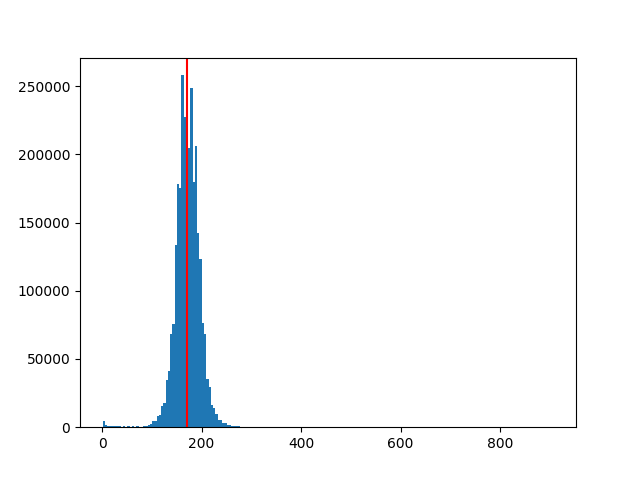

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


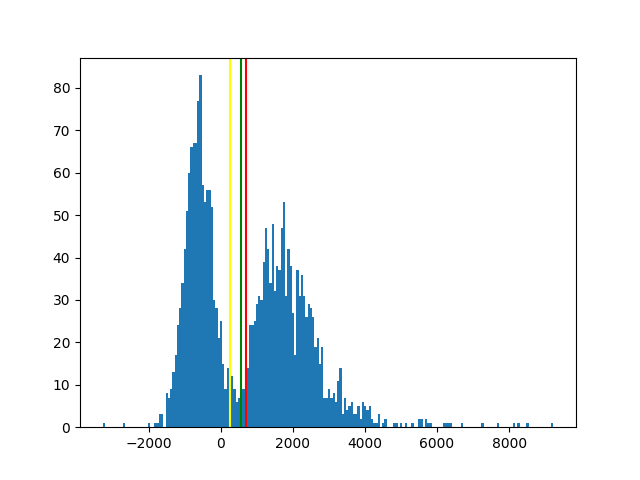

<IPython.core.display.Javascript object>


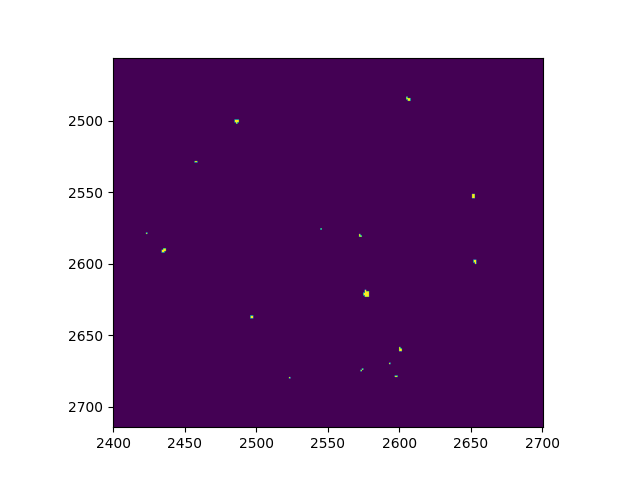

2384


In [248]:
show_hists(results[22], 0.4, 1)

0.5391839083895996


<IPython.core.display.Javascript object>


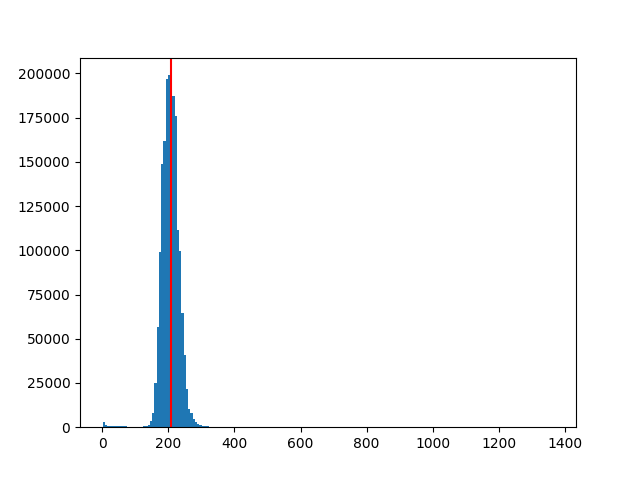

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


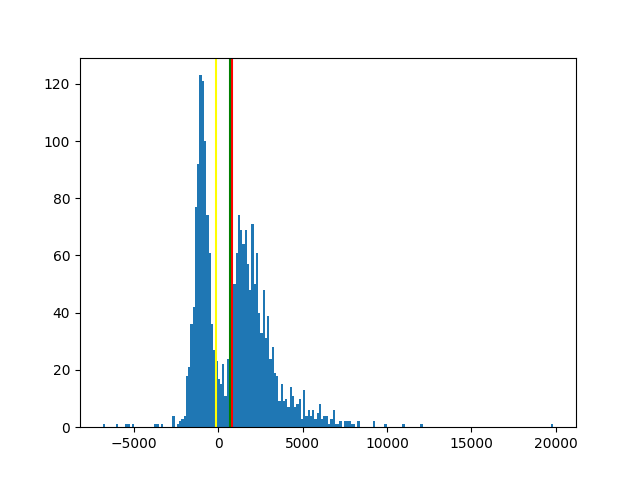

<IPython.core.display.Javascript object>


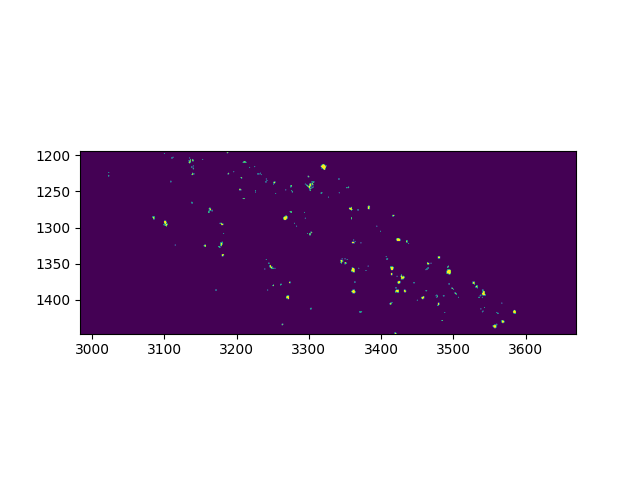

2168


In [249]:
show_hists(results[23], 0.3, 1)

-1.177281895831621


<IPython.core.display.Javascript object>


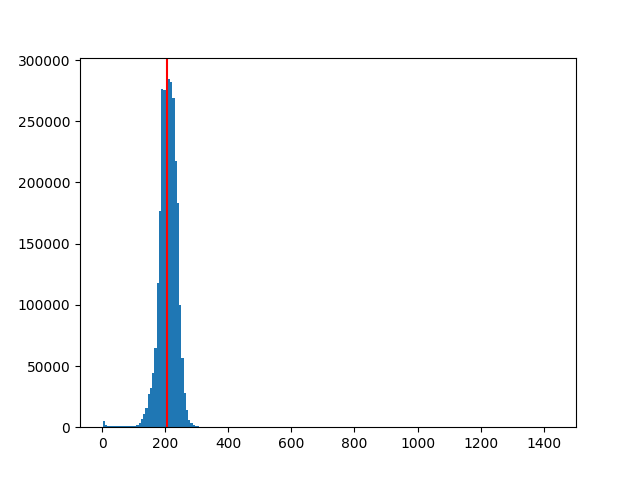

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


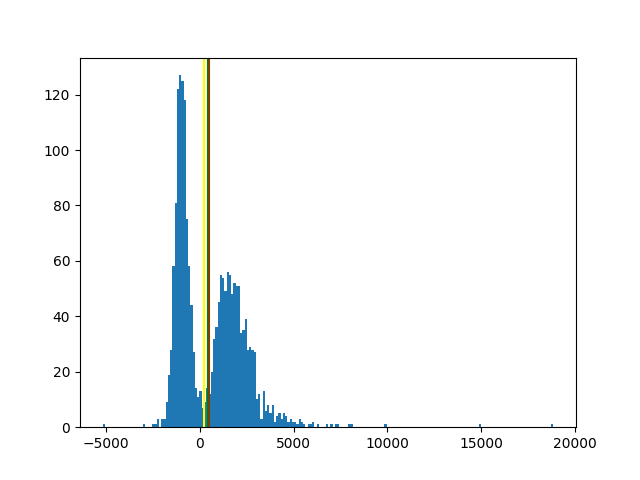

<IPython.core.display.Javascript object>


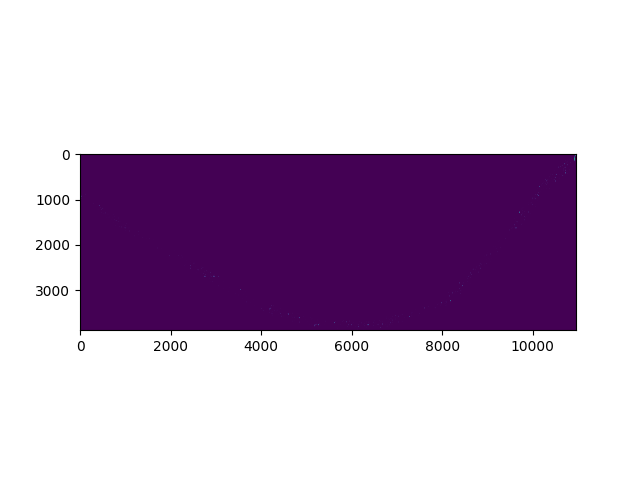

1926


In [250]:
show_hists(results[24], 0.3, 1)

12.361037063043337


<IPython.core.display.Javascript object>


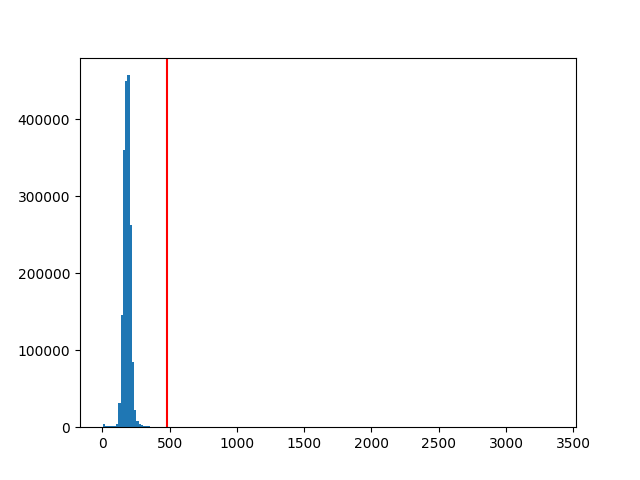

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


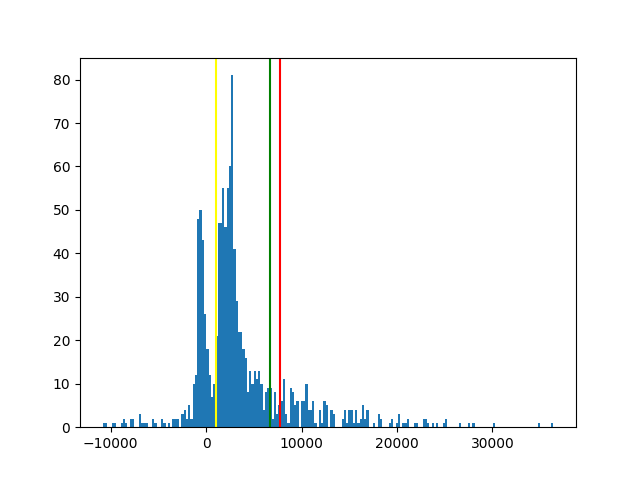

<IPython.core.display.Javascript object>


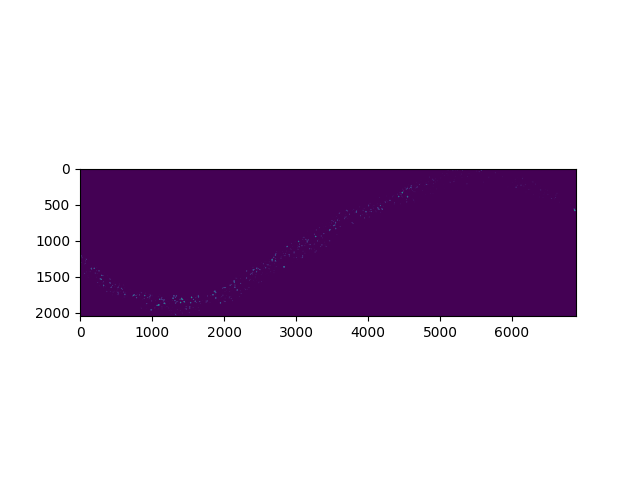

1147


In [257]:
show_hists(results[25], 0.2, 1)

-0.6561744517391926


<IPython.core.display.Javascript object>


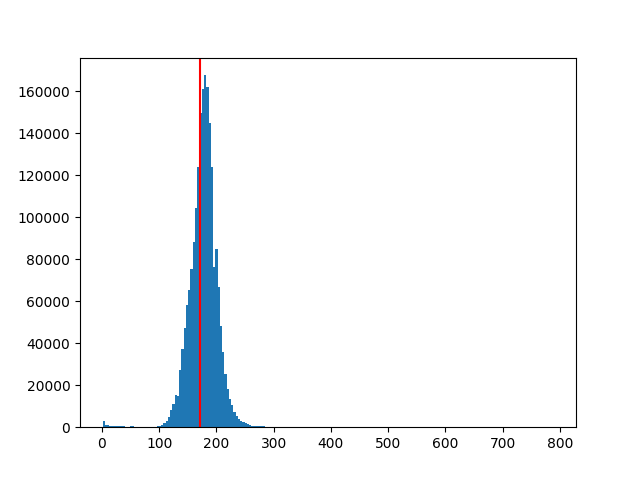

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


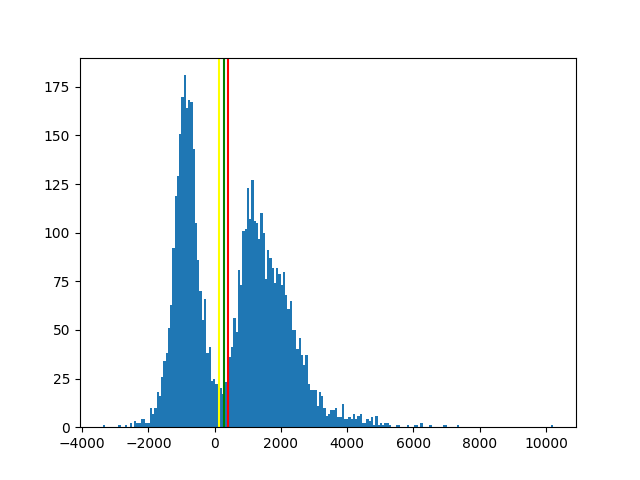

<IPython.core.display.Javascript object>


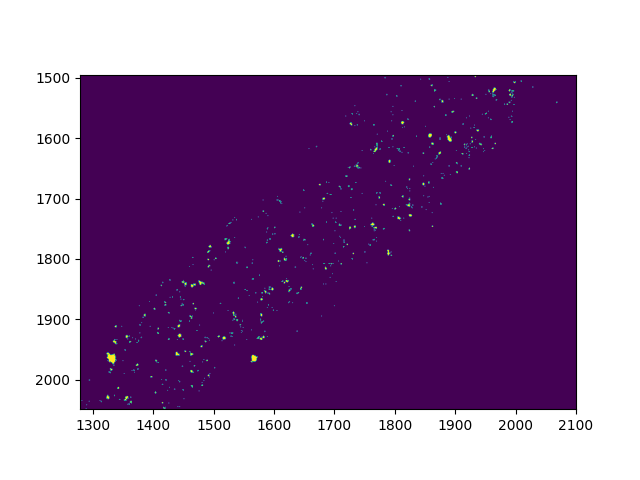

5335


In [252]:
show_hists(results[26], 0.3, 1)

1.8677348884526708


<IPython.core.display.Javascript object>


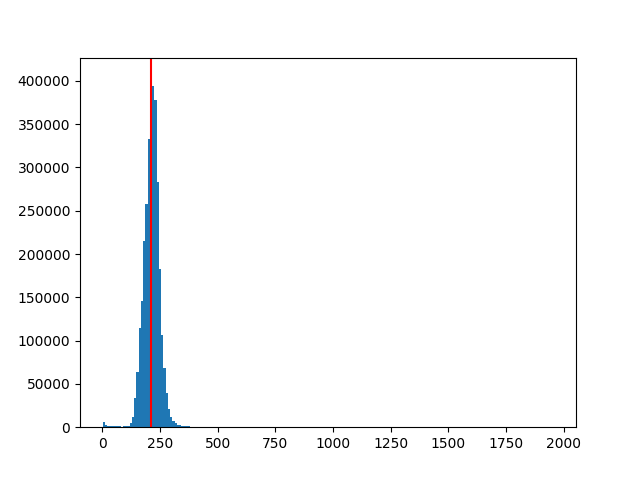

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


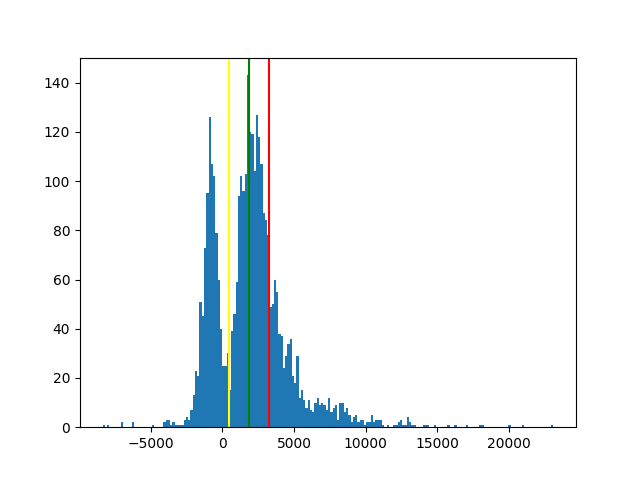

<IPython.core.display.Javascript object>


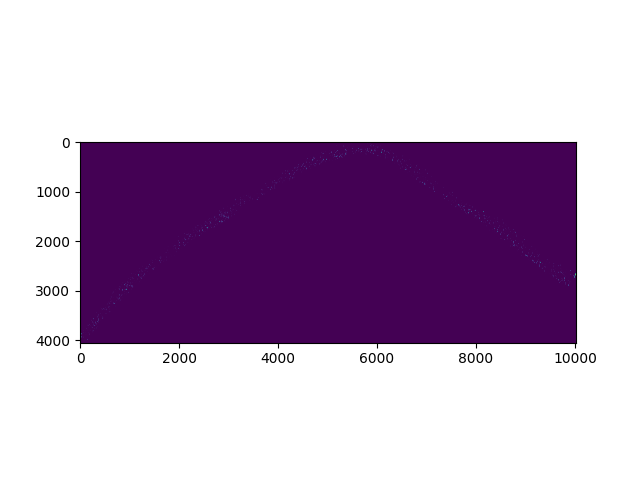

3350


In [259]:
show_hists(results[27], 0.4, 1)

-0.8877997760437871


<IPython.core.display.Javascript object>


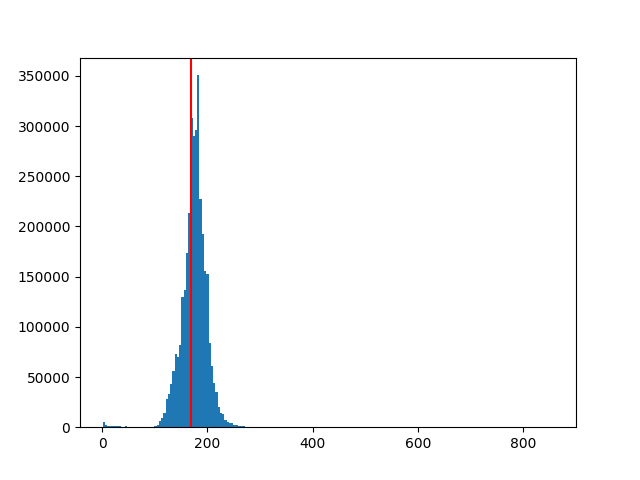

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


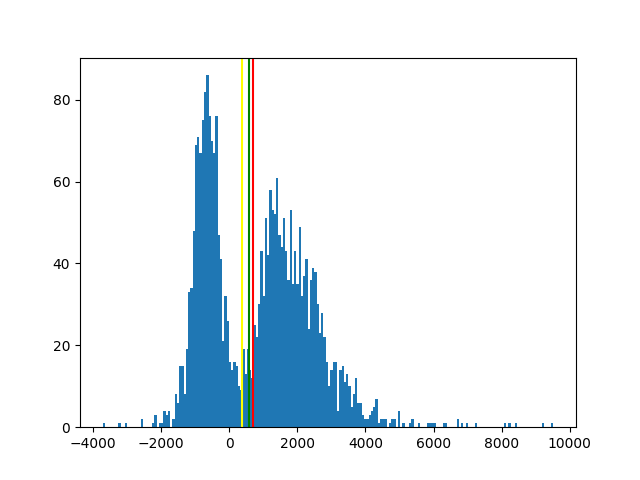

<IPython.core.display.Javascript object>


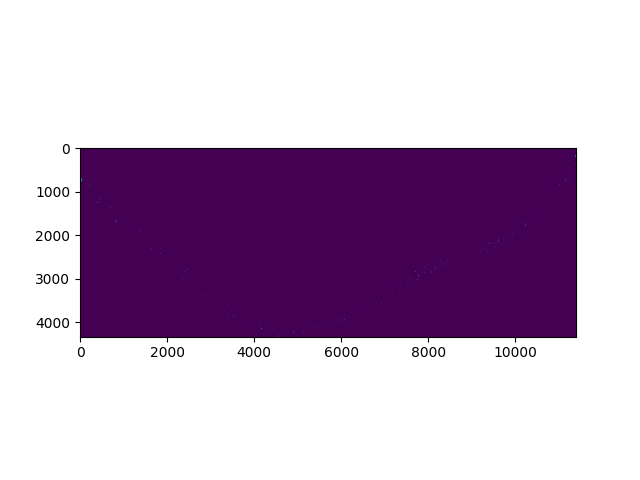

2767


In [260]:
show_hists(results[28], 0.4, 1)

-0.3087022618283557


<IPython.core.display.Javascript object>


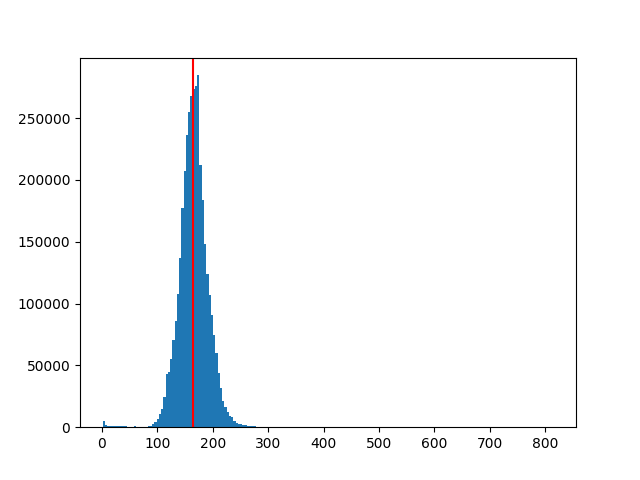

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


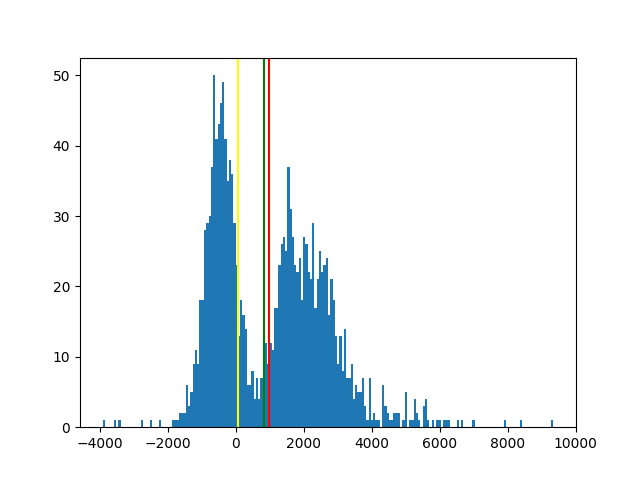

<IPython.core.display.Javascript object>


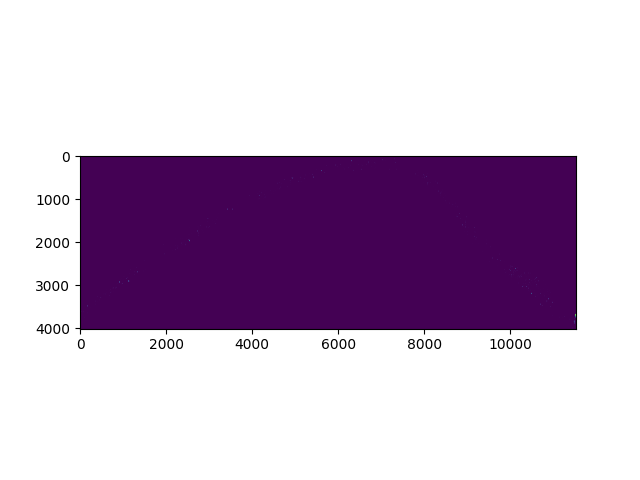

1611


In [262]:
show_hists(results[29], 0.5, 1)

0.22261558102348958


<IPython.core.display.Javascript object>


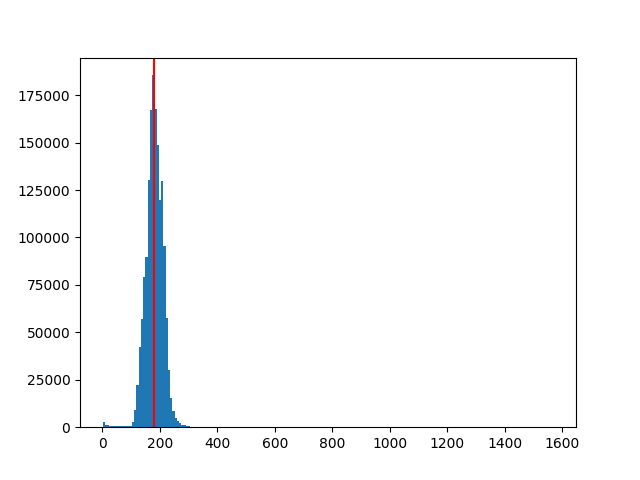

<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


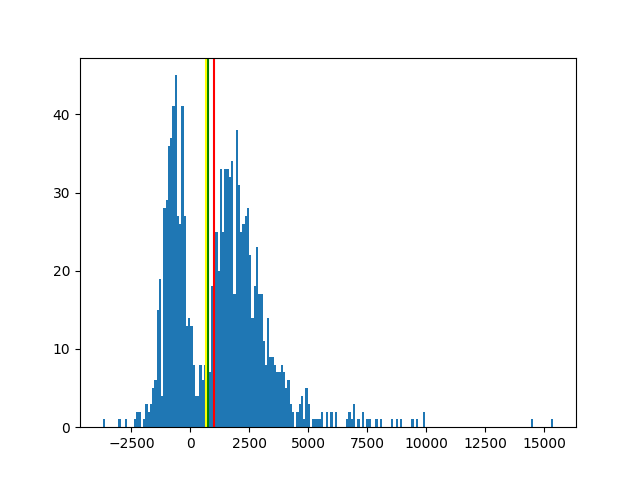

<IPython.core.display.Javascript object>


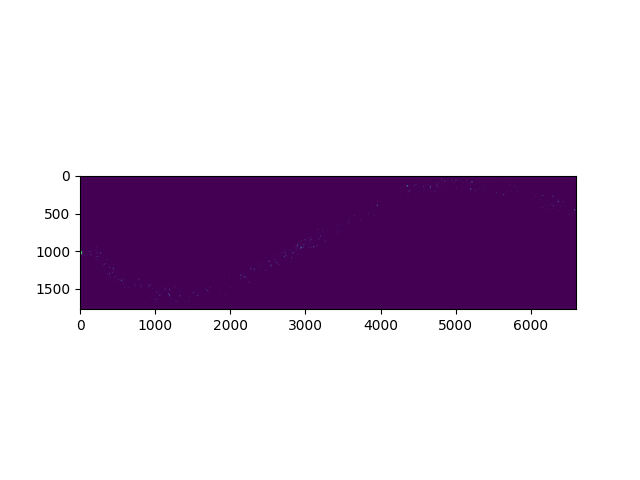

1227


In [263]:
show_hists(results[30], 0.4, 1)

In [79]:
for result in results:
    print(len(result.dots))

1805
55371
2181
2276
1116
39925
1822
1125
21160
1634
1716
31559
1682
1733
2057
1692
1906
261
47784
1439
580
1653
1685
1165
2131
39486
1295
1831
2399
1986
1191


In [92]:
def plot_chosen_dots(result, add_dots=[]):
    ax = plt.subplot(aspect='equal')
    plt.ioff()
    ieg_img = io.imread(result.path + "/2.tif")

    plt.imshow(ieg_img)
    
    for dot in result.dots:
        ax.add_artist(dot.approx_patch)    
    for dot in add_dots:
        ax.add_artist(dot.approx_patch)
    
    plt.show()

In [93]:
plot_chosen_dots(results[3])

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

In [246]:
def custom_intensity_thre(intensities_normalized):
    hist, bins = np.histogram(intensities_normalized, 200)

    bin_mids = np.array([int((a + b) / 2) for a, b in zip(bins[1:], bins[:-1])])
    peaks, _ = find_peaks(hist, distance=8)

    largest_peak_vals = sorted(hist[peaks])[-2:]
    lp_idxs = np.isin(hist, largest_peak_vals)
    return np.average(bin_mids[lp_idxs])


<ipython-input-33-38ccd6f41f1f>:6: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3,3)),
/home/user/.local/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


<IPython.core.display.Javascript object>


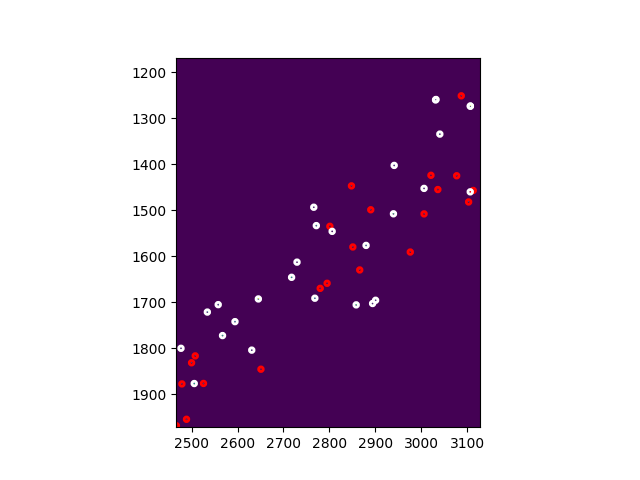

In [184]:
result = results[0]

ieg_img = io.imread(result.path + "/2.tif")
mask = ieg_img > (result.thre + result.bgr*0.4)
dots, intensities_normalized = ieg_segmentation(ieg_img, 0, 30, 21, mask)
intensity_thre = threshold_otsu(intensities_normalized)

ax = plt.subplot(aspect='equal')
plt.ioff()

plt.imshow(mask)

for dot in dots:
    if dot.intensity > custom_intensity_thre(intensities_normalized):
        dot.approx_patch.set_edgecolor("white")
    ax.add_artist(dot.approx_patch)

    
    
plt.show()

In [275]:
for result in results:
    #to do poprawy - drugi raz liczę to samo
    intensities = np.array([])
    for dot in result.dots():
        intensities = np.append(intensities, dot.intensity)
    result.thre = custom_intensity_thre(intensities)
    with open(result.path + csv_suffix, 'w', newline='') as csvfile:
        fieldnames = ['centroid_x', 'centroid_y', 'intensity']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for dot in result.dots:
            if dot.intensity > result.thre:
                dot_centroid = dot.approx_patch.center
                writer.writerow({'centroid_x': dot_centroid[0],'centroid_y': dot_centroid[1], 'intensity': dot.intensity})
            

In [272]:
circ = mpatches.Circle((1, 5), 5, fill=False, edgecolor='red', linewidth=2)

In [273]:
circ.center

(1, 5)

In [ ]:
c